# Figures 

## SOSE

In [1]:
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import fsspec
import xmitgcm
from xhistogram.xarray import histogram
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon
%matplotlib inline
import gsw
from fastjmd95 import jmd95numba
from fastjmd95 import rho, drhods, drhodt
import json

In [2]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))
wmt_budget_terms.load()

/tmp/ipykernel_371/535204962.py:1: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  wmt_budget_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/wmt_budget_terms.zarr'))


<xarray.Dataset>
Dimensions:               (time: 438, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_slt                (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_th                 (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R2                    (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_slt                (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_th                 (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    ...                    ...
    omega_total_th        (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate      (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate_slt  (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_trans_rate_th   (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv               (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel               (time, sigma2_bin) float64 -1.318e+07 ... -0.0

In [4]:
omega_surf = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/datasets/wmt_budget_terms/omega_surf.zarr'))
omega_surf.load()

<xarray.Dataset>
Dimensions:         (time: 438, sigma2_bin: 999)
Coordinates:
  * sigma2_bin      (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time            (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    omega_surf      (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_slt  (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_th   (time, sigma2_bin) float32 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [5]:
#get rid of old surf terms and add corrected surf terms to wmt ds
wmt = xr.merge([wmt_budget_terms.drop(['omega_surf', 'omega_surf_slt', 'omega_surf_th']),
                omega_surf])

In [6]:
wmt

<xarray.Dataset>
Dimensions:               (time: 438, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_slt                (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_th                 (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R2                    (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_slt                (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_th                 (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    ...                    ...
    omega_trans_rate_th   (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv               (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel               (time, sigma2_bin) float64 -1.318e+07 ... -0.0
    omega_surf            (time, sigma2_bin) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_slt        (time, sigma2_bin) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_th         (time, sigma2_bin) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [7]:
wmt_budget_terms = wmt.sel(time=slice('2006', '2010'))

In [8]:
#indices
indices = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/SOSE/datasets/indices.zarr')).load()

## Time mean budgets

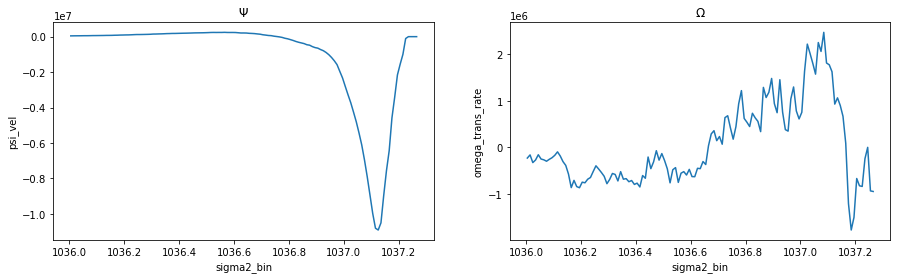

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1036.0, 1037.27)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

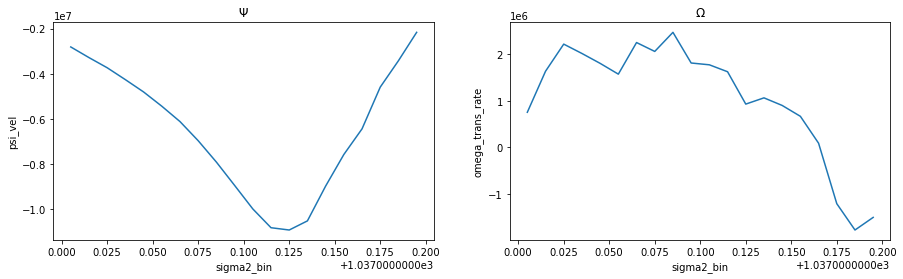

In [10]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037, 1037.2)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1037, 1037.2)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

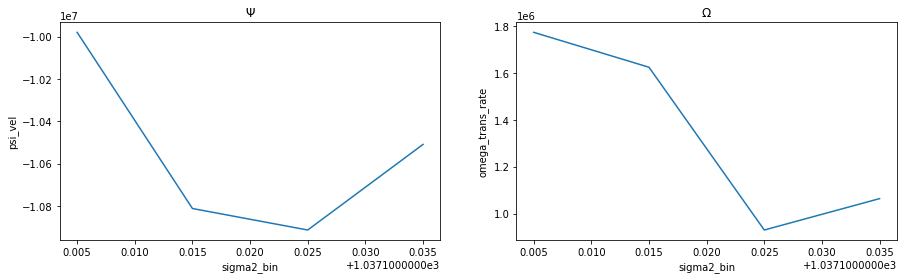

In [11]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(15,4))
wmt_budget_terms.psi_vel.mean('time').sel(sigma2_bin=slice(1037.1, 1037.14)).plot(ax=ax0)
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=slice(1037.1, 1037.14)).plot(ax=ax1)
ax0.set_title(r'$\Psi$')
ax1.set_title(r'$\Omega$');

### $\frac{\partial V}{\partial t}$

In [12]:
bottom = (wmt_budget_terms.mean('time').isel(sigma2_bin=-1) - 
          wmt_budget_terms.mean('time').sel(sigma2_bin=1037.125, method='nearest'))/1e6
deep = (wmt_budget_terms.mean('time').sel(sigma2_bin=1037.125, method='nearest') - 
        wmt_budget_terms.mean('time').isel(sigma2_bin=0))/1e6

In [13]:
bottom.dVdt

<xarray.DataArray 'dVdt' ()>
array(7.85113034)

In [14]:
bottom.dVdt + deep.dVdt

<xarray.DataArray 'dVdt' ()>
array(0.)

### E-P-R

### $\Psi$

In [15]:
bottom.psi_vel + deep.psi_vel

<xarray.DataArray 'psi_vel' ()>
array(-0.00366238)

### $\Omega$

In [16]:
bottom.omega_trans_rate + deep.omega_trans_rate

<xarray.DataArray 'omega_trans_rate' ()>
array(0.)

In [17]:
#transformation at the boundary between bottom/dm wm
wmt_budget_terms.omega_trans_rate.mean('time').sel(sigma2_bin=1037.125, method='nearest')/1e6

<xarray.DataArray 'omega_trans_rate' ()>
array(0.92951455)
Coordinates:
    sigma2_bin  float64 1.037e+03

In [20]:
terms_on_boundary = wmt_budget_terms.sel(sigma2_bin=1037.125, method='nearest')/1e6
terms_on_boundary

<xarray.Dataset>
Dimensions:               (time: 366)
Coordinates:
    sigma2_bin            float64 1.037e+03
  * time                  (time) datetime64[ns] 2006-01-01 ... 2010-12-31
Data variables: (12/24)
    R1                    (time) float64 1.543 -2.355 -4.803 ... 0.4932 0.7711
    R1_slt                (time) float64 -11.05 -19.92 -19.12 ... -13.85 -5.555
    R1_th                 (time) float64 -4.189 -2.456 -4.33 ... 5.573 -1.514
    R2                    (time) float64 10.26 1.859 4.367 ... -0.06547 -0.2306
    R2_slt                (time) float64 26.71 22.84 23.04 ... 8.608 14.44 6.348
    R2_th                 (time) float64 -1.039 -7.516 -4.471 ... -7.019 -0.1373
    ...                    ...
    omega_trans_rate_th   (time) float64 3.866 3.422 4.353 ... 0.1593 0.2521
    psi_adv               (time) float64 -5.16 -11.61 -9.831 ... -7.548 -6.672
    psi_vel               (time) float64 -15.42 -13.47 -14.2 ... -7.482 -6.441
    omega_surf            (time) float32 -15.26 -7.923 -6.79 ... -0.53 -0.7911
    omega_surf_slt        (time) float32 -9.226 -0.8849 -0.7589 ... 0.0 0.0
    omega_surf_th         (time) float32 -6.035 -7.038 -6.031 ... -0.53 -0.7911

In [18]:
terms_on_boundary_polynyaYr = wmt.sel(sigma2_bin=1037.125, method='nearest')/1e6
terms_on_boundary_polynyaYr

<xarray.Dataset>
Dimensions:               (time: 438)
Coordinates:
    sigma2_bin            float64 1.037e+03
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables: (12/24)
    R1                    (time) float64 nan 0.5529 -1.479 ... 0.4932 0.7711
    R1_slt                (time) float64 nan -26.66 -19.26 ... -13.85 -5.555
    R1_th                 (time) float64 nan 5.735 -4.333 ... 5.573 -1.514
    R2                    (time) float64 -9.636 -3.018 ... -0.06547 -0.2306
    R2_slt                (time) float64 -4.847 23.22 14.41 ... 14.44 6.348
    R2_th                 (time) float64 17.45 -16.73 -6.403 ... -7.019 -0.1373
    ...                    ...
    omega_trans_rate_th   (time) float64 16.85 -0.9778 -0.8319 ... 0.1593 0.2521
    psi_adv               (time) float64 -31.88 -12.53 -13.08 ... -7.548 -6.672
    psi_vel               (time) float64 -22.24 -9.512 -10.54 ... -7.482 -6.441
    omega_surf            (time) float32 1.896 -4.516 -3.435 ... -0.53 -0.7911
    omega_surf_slt        (time) float32 9.367 -0.3385 0.0 ... 0.4931 0.0 0.0
    omega_surf_th         (time) float32 -7.471 -4.177 -3.435 ... -0.53 -0.7911

In [21]:
#boundary omegas
omegas = list()
bdy_omegas = list()

for var in terms_on_boundary.data_vars:
    if var == 'omega_total':
        continue 
    elif var == 'omega_total_slt':
        continue
    elif var == 'omega_total_th':
        continue
    elif var.startswith('omega'):
        omegas.append(var)
        bdy_omegas.append(terms_on_boundary.drop('sigma2_bin').data_vars[var])

In [22]:
#boundary omegas
omegas_polynyaYr = list()
bdy_omegas_polynyaYr = list()

for var in terms_on_boundary_polynyaYr.data_vars:
    if var == 'omega_total':
        continue 
    elif var == 'omega_total_slt':
        continue
    elif var == 'omega_total_th':
        continue
    elif var.startswith('omega'):
        omegas_polynyaYr.append(var)
        bdy_omegas_polynyaYr.append(terms_on_boundary_polynyaYr.drop('sigma2_bin').data_vars[var])

In [23]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th']

In [24]:
omegas_polynyaYr

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th']

In [25]:
bdy_omegas[:1]

[<xarray.DataArray 'omega_mix' (time: 366)>
 array([  2.09881031,   1.87011965,   2.77637387,   2.69253504,
          3.7982062 ,   0.40334592,   2.4158184 ,   2.61446077,
          1.39451981,   0.76823121,   1.05759401,   0.8254623 ,
          1.33633433,   1.46038406,   1.21142056,   1.16788609,
          0.84006708,   0.99099028,   1.09024378,   0.63865783,
         -0.03315579,   0.76011369,  -0.35429743,   0.48293228,
          0.82399443,   6.01869899,   5.68656777,   4.84888071,
          5.34079066,   5.22080462,   6.20189353,   5.8529124 ,
          6.21180351,   7.34535321,   8.43443141,   9.32505859,
          3.72607878,   3.98618801,   4.38214847,   4.81778513,
          3.4227974 ,   5.28201792,   4.79601819,   5.13090996,
          5.96752488,   5.51737551,   6.35831286,   7.14323867,
          7.83138249,   8.27844278,   7.64982297,   6.79364403,
          5.87480475,   4.7338028 ,   4.93525623,   4.48481283,
          4.22022408,   4.76561979,   1.00103043,   0.201461

In [26]:
len(omegas)

9

In [27]:
len(bdy_omegas)

9

In [28]:
for i in range(9):
    print(bdy_omegas[i].name)

omega_mix
omega_mix_slt
omega_mix_th
omega_trans_rate
omega_trans_rate_slt
omega_trans_rate_th
omega_surf
omega_surf_slt
omega_surf_th


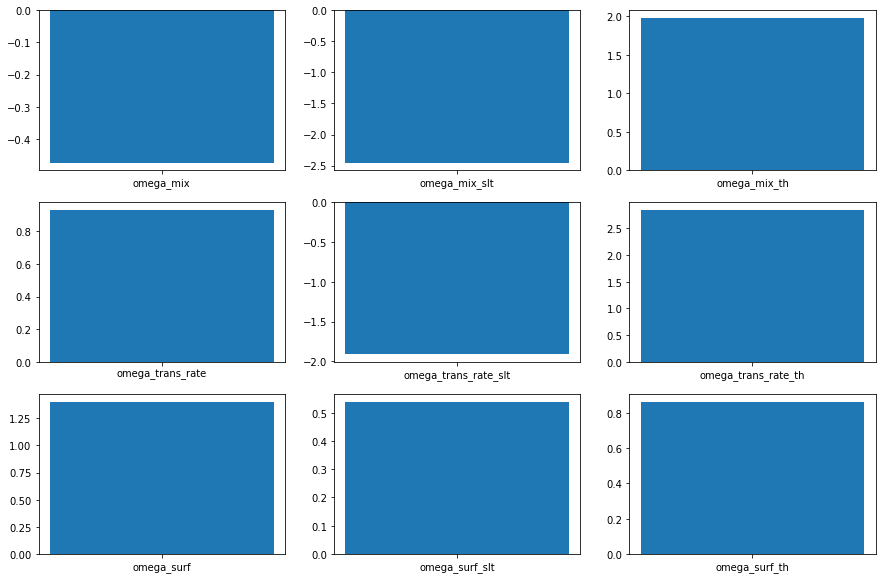

In [25]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax = ax.ravel()

for i in range(9):
    ax[i].bar(x=bdy_omegas[i].name, height=bdy_omegas[i].mean('time').values)

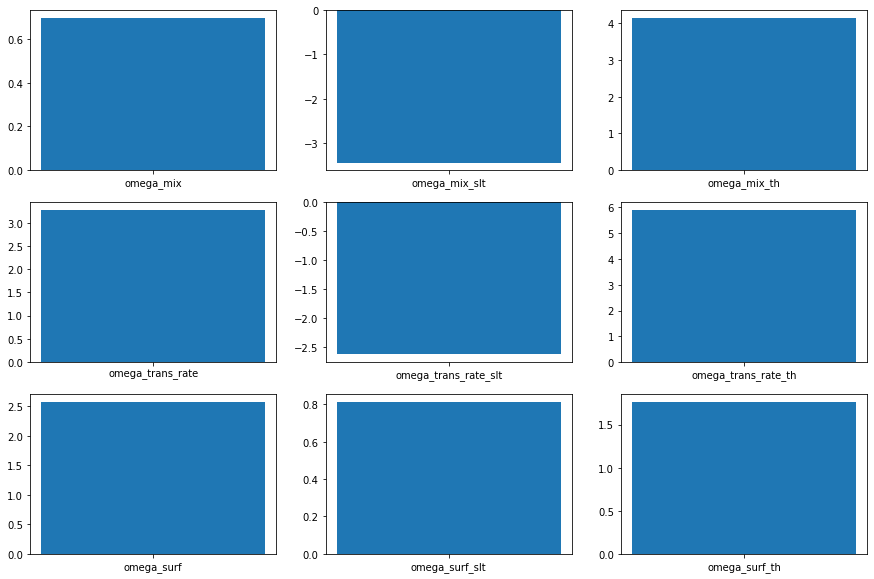

In [29]:
fig, ax = plt.subplots(3,3, figsize=(15,10))
ax = ax.ravel()

for i in range(9):
    ax[i].bar(x=bdy_omegas_polynyaYr[i].name, height=bdy_omegas_polynyaYr[i].mean('time').values)

In [26]:
- bottom.omega_trans_rate + bottom.omega_mix + bottom.omega_surf

<xarray.DataArray ()>
array(-6.64454443e-07)

In [27]:
(- bdy_omegas[3] + bdy_omegas[0] + bdy_omegas[6]).mean('time')

<xarray.DataArray ()>
array(2.40032342e-07)

In [28]:
bottom.omega_trans_rate

<xarray.DataArray 'omega_trans_rate' ()>
array(-0.92951455)

In [29]:
bdy_omegas[3].mean('time')

<xarray.DataArray 'omega_trans_rate' ()>
array(0.92951455)

In [30]:
bottom.omega_mix + bottom.omega_surf

<xarray.DataArray ()>
array(-0.92951522)

In [31]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th']

In [32]:
bdy_omegas[6].name

'omega_surf'

In [33]:
(bdy_omegas[0] + bdy_omegas[6]).mean('time')

<xarray.DataArray ()>
array(0.92951479)

### Bottom $\Omega$s

### Boundary $\Omega$s

### Budget

* $\frac{\partial V}{\partial t} = \Omega_{total} + R1$ $\Omega_{total} \equiv$ hist(weights=tottend); tottend = $\sigma$.diff(time)*vol / $\Delta$ t
* $\Omega_{trans-rate}$
* $\Psi_{adv} = \Psi_{vel} + R2$
* $R3 = \Omega_{total} - \Psi_{adv} - \Omega_{trans-rate}$
* $\frac{\partial V}{\partial t} = \Psi_{vel} + R2 + \Omega_{trans-rate} + R3 + R1$

__SWITCH SIGN OF ALL TERMS SINCE CUM VOL WAS DEFINED $\int_{\sigma_{max}}^{\sigma_{min}}$ (instead of $\int_{\sigma_{min}}^{\sigma_{max}}$) in wmt budget `poster-figs-sigma-ecco-ts-components-SOSEperiod.ipynb`__

* $\frac{\partial V}{\partial t}$ is (+ to -) for bottom wm, (- to +) for deep wm
   * (No longer cumulative volume!) Decreasing rate of volume means less water in wm; conversely, increasing rate of volume means more water in wm.
* $\Psi$ is (+ to -) for bottom wm, (- to +) for deep wm
   * Negative $\Psi$ means OUTflow, positive $\Psi$ means INflow
* $\Omega$ is (- to +) for bottom wm, (+ to -) for deep wm
   * using only one $\Omega$ (on the boundary) yields a positive value, which means positive transformation of deep layer water being added to bottom layer. (+) into layer 2 (bottom) is trying to add volume, (-) from layer 1 (deep) is trying to remove volume.

In [34]:
print('bottom:', bottom.dVdt.values, ' deep:', deep.dVdt.values)

bottom: 7.8511303397344685  deep: -7.8511303397344685


In [35]:
print('bottom:', bottom.psi_vel.values, ' deep:', deep.psi_vel.values)

bottom: 10.912995383450237  deep: -10.916657766305363


In [36]:
print('bottom:', bottom.omega_trans_rate.values, ' deep:', deep.omega_trans_rate.values)

bottom: -0.9295145522728198  deep: 0.9295145522728198


In [30]:
bottom = -bottom
deep = -deep

In [38]:
print('correct bottom:', bottom.dVdt.values, ' correct deep:', deep.dVdt.values)

correct bottom: -7.8511303397344685  correct deep: 7.8511303397344685


In [39]:
print('correct bottom:', bottom.psi_vel.values, ' correct deep:', deep.psi_vel.values)

correct bottom: -10.912995383450237  correct deep: 10.916657766305363


In [40]:
print('correct bottom:', bottom.omega_trans_rate.values, ' correct deep:', deep.omega_trans_rate.values)

correct bottom: 0.9295145522728198  correct deep: -0.9295145522728198


### __Bottom budget__

In [41]:
- bottom.dVdt + bottom.psi_vel + bottom.omega_trans_rate + bottom.R1 + bottom.R2

<xarray.DataArray ()>
array(0.00017237)

In [42]:
- bottom.dVdt + bottom.psi_vel + bottom.omega_trans_rate #w/o residuals

<xarray.DataArray ()>
array(-2.13235049)

In [43]:
- bottom.dVdt + bottom.psi_vel + bottom.R2 + bdy_omegas[3].mean('time') + bottom.R1 

<xarray.DataArray ()>
array(0.00017237)

In [44]:
- bottom.dVdt + bottom.psi_vel + bdy_omegas[3].mean('time') #w/o residuals

<xarray.DataArray ()>
array(-2.13235049)

### __Deep budget__

In [45]:
- deep.dVdt + deep.psi_vel + deep.R2 + deep.omega_trans_rate + deep.R1 

<xarray.DataArray ()>
array(-0.00017237)

In [46]:
- deep.dVdt + deep.psi_vel + deep.R2 - bdy_omegas[3].mean('time') + deep.R1 

<xarray.DataArray ()>
array(-0.00017237)

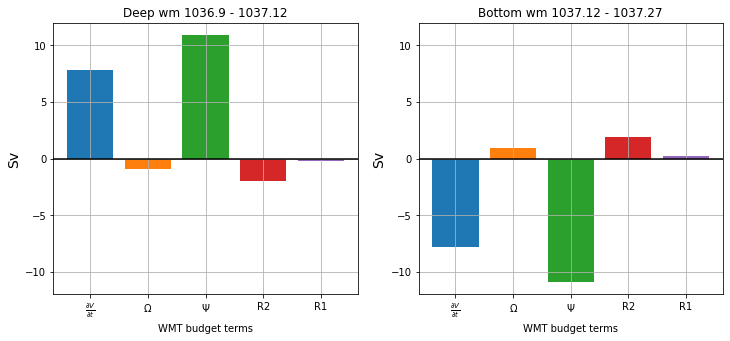

In [31]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt)
ax0.bar(x=r'$\Omega$', height = deep.omega_trans_rate)
ax0.bar(x=r'$\Psi$', height=deep.psi_vel)
ax0.bar(x='R2', height=deep.R2)
ax0.bar(x='R1', height=deep.R1)
ax0.axhline(y=0, color='k')
ax0.set_title('Deep wm 1036.9 - 1037.12')
ax0.set_ylabel('Sv', fontsize=14)
ax0.set_xlabel('WMT budget terms')
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt)
ax1.bar(x=r'$\Omega$', height = bottom.omega_trans_rate)
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel)
ax1.bar(x='R2', height=bottom.R2)
ax1.bar(x='R1', height=bottom.R1)
ax1.axhline(y=0, color='k')
ax1.set_title('Bottom wm 1037.12 - 1037.27')
ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms')
ax1.grid()
ax1.set_ylim(-12,12);

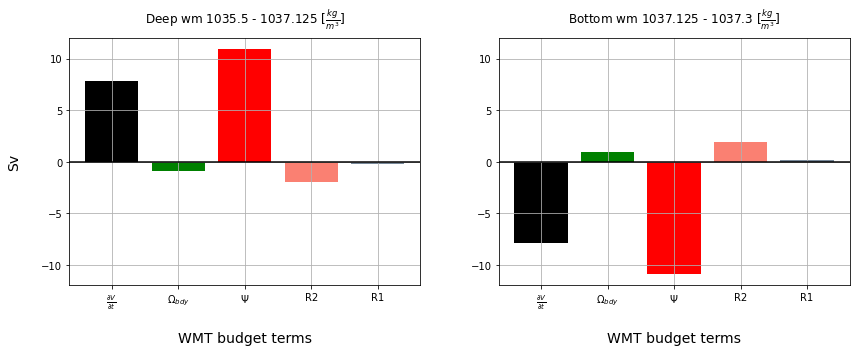

In [32]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt, color='k')
ax0.bar(x=r'$\Omega_{bdy}$', height = - bdy_omegas[3].mean('time'), color='green')
ax0.bar(x=r'$\Psi$', height= deep.psi_vel, color='red')
ax0.bar(x='R2', height=deep.R2, color='salmon')
ax0.bar(x='R1', height=deep.R1, color='lightslategray')
ax0.axhline(y=0, color='k')
ax0.set_title(r'Deep wm 1035.5 - 1037.125 [$\frac{kg}{m^3}$]', pad=15)
ax0.set_ylabel('Sv', fontsize=14, labelpad=20)
ax0.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt, color='k')
ax1.bar(x=r'$\Omega_{bdy}$', height = bdy_omegas[3].mean('time'), color='green')
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel, color='red')
ax1.bar(x='R2', height=bottom.R2, color='salmon')
ax1.bar(x='R1', height=bottom.R1, color='lightslategray')
ax1.axhline(y=0, color='k')
ax1.set_title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
#ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-12,12)
plt.tight_layout(w_pad=5);

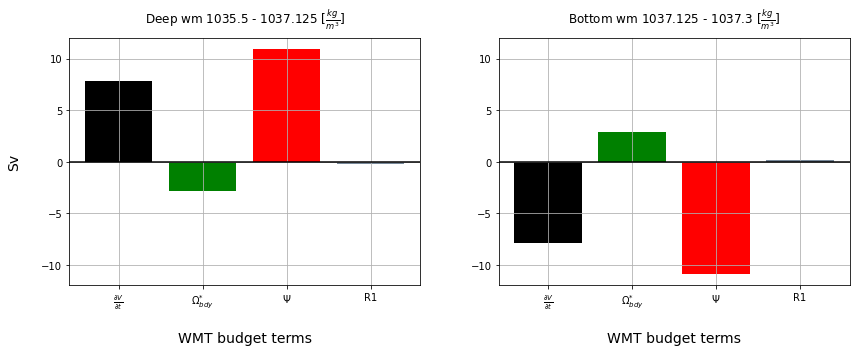

In [33]:
#R2 included in omega term (denoted as omega*)
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,5))

ax0.bar(x=r'$\frac{\partial V}{\partial t}$', height = deep.dVdt, color='k')
ax0.bar(x=r'$\Omega^{*}_{bdy}$', height = (- bdy_omegas[3].mean('time') + deep.R2), color='green')
ax0.bar(x=r'$\Psi$', height= deep.psi_vel, color='red')
ax0.bar(x='R1', height=deep.R1, color='lightslategray')
ax0.axhline(y=0, color='k')
ax0.set_title(r'Deep wm 1035.5 - 1037.125 [$\frac{kg}{m^3}$]', pad=15)
ax0.set_ylabel('Sv', fontsize=14, labelpad=20)
ax0.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax0.grid()
ax0.set_ylim(-12,12)

ax1.bar(x=r'$\frac{\partial V}{\partial t}$', height = bottom.dVdt, color='k')
ax1.bar(x=r'$\Omega^{*}_{bdy}$', height = (bdy_omegas[3].mean('time')+bottom.R2), color='green')
ax1.bar(x=r'$\Psi$', height=bottom.psi_vel, color='red')
ax1.bar(x='R1', height=bottom.R1, color='lightslategray')
ax1.axhline(y=0, color='k')
ax1.set_title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
#ax1.set_ylabel('Sv', fontsize=14)
ax1.set_xlabel('WMT budget terms', fontsize=14, labelpad=20)
ax1.grid()
ax1.set_ylim(-12,12)
plt.tight_layout(w_pad=5);

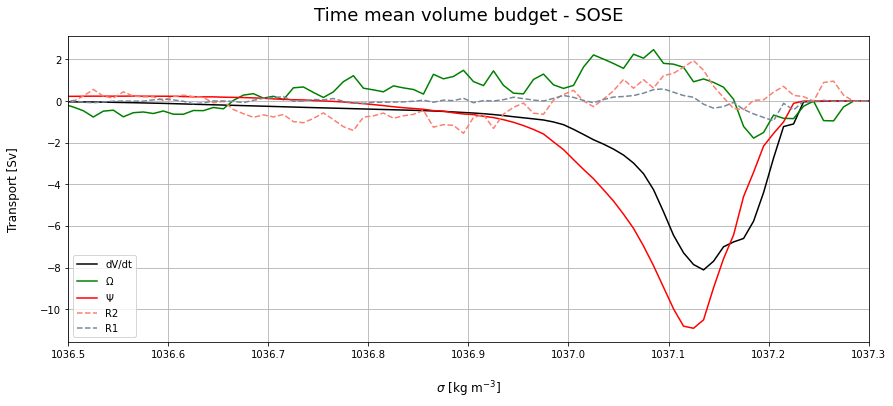

In [34]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green')
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='red')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray', linestyle='--')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
plt.title(r'Time mean volume budget - SOSE', fontsize=18, pad=15)
plt.xlim(1036.5, 1037.3);

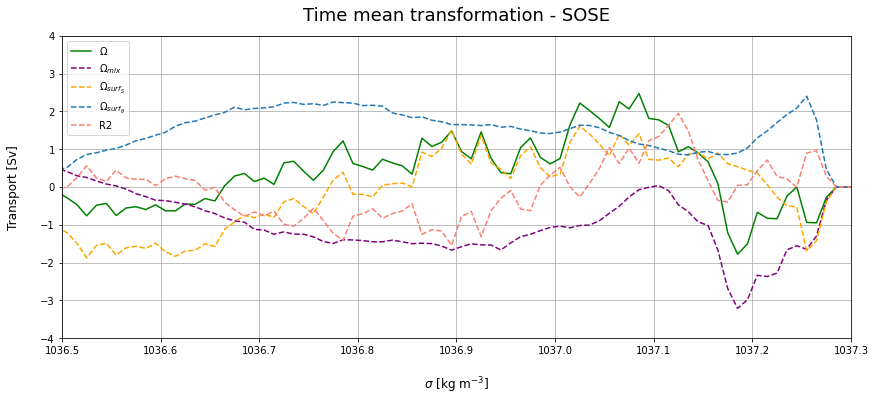

In [35]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(label=r'$\Omega$', color='green', figsize=(12,5))
#(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue', linestyle='dashed')
#(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod', linestyle='dashed')
(wmt_budget_terms.omega_mix/1e6).mean(dim='time').plot(label=r'$\Omega_{mix}$', color='purple', linestyle='dashed')
(wmt_budget_terms.omega_surf_slt/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_S}$', color='orange', linestyle='dashed')
(wmt_budget_terms.omega_surf_th/1e6).mean(dim='time').plot(label=r'$\Omega_{surf_\theta}$', color='C0', linestyle='dashed')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon', linestyle='--')

plt.legend()
plt.grid()
plt.ylim(-4, 4)
plt.xlim(1036.5, 1037.3)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12, labelpad=20)
plt.ylabel(r'Transport [Sv]', fontsize=12, labelpad=20)
plt.title('Time mean transformation - SOSE', fontsize=18, pad=15);

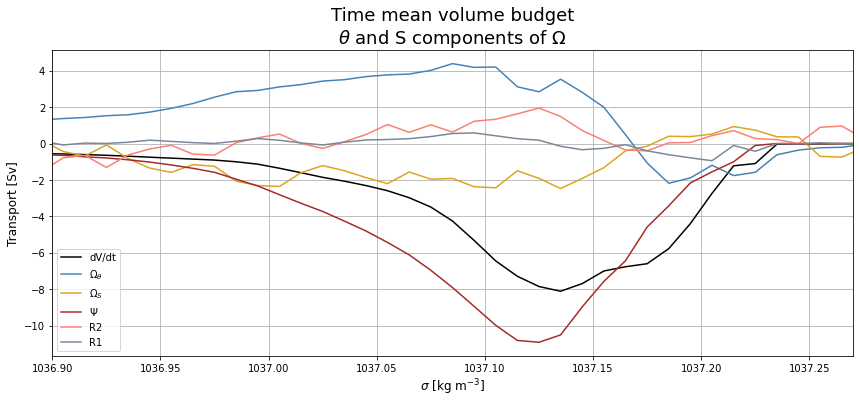

In [36]:
(wmt_budget_terms.dVdt/1e6).mean(dim='time').plot(label='dV/dt', color='k', figsize=(12,5))
(wmt_budget_terms.omega_trans_rate_th/1e6).mean(dim='time').plot(label=r'$\Omega_{\theta}$', color='steelblue')
(wmt_budget_terms.omega_trans_rate_slt/1e6).mean(dim='time').plot(label=r'$\Omega_S$', color='goldenrod')
(wmt_budget_terms.psi_vel/1e6).mean(dim='time').plot(label=r'$\Psi$', color='brown')
(wmt_budget_terms.R2/1e6).mean(dim='time').plot(label='R2', color='salmon')
(wmt_budget_terms.R1/1e6).mean(dim='time').plot(label='R1', color='lightslategray')
#(R3[1:-1]/1e6).mean(dim='time').plot(label=r'$R3$', color='mediumspringgreen')
plt.legend()
plt.grid()
#plt.ylim(-12, 12)
plt.xlim(1036.90, 1037.27)
plt.tight_layout()
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title("Time mean volume budget\n" r'$\theta$ and S components of $\Omega$', fontsize=18);

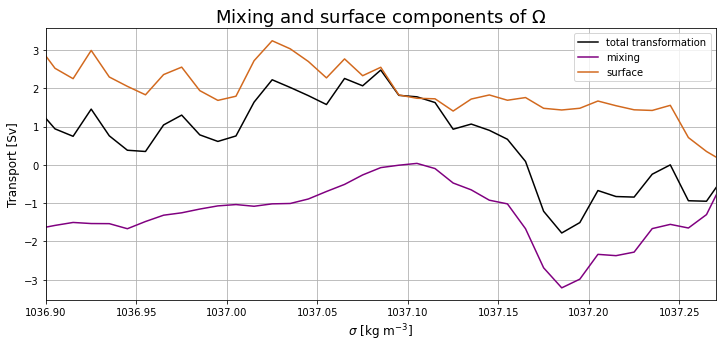

In [37]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total transformation', color='k')#, marker='.')
(wmt_budget_terms.omega_mix/1e6).mean(dim='time').plot(label='mixing', color='purple')
(wmt_budget_terms.omega_surf/1e6).mean(dim='time').plot(label='surface', color='chocolate')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-6, 6)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'Mixing and surface components of $\Omega$', fontsize=18);

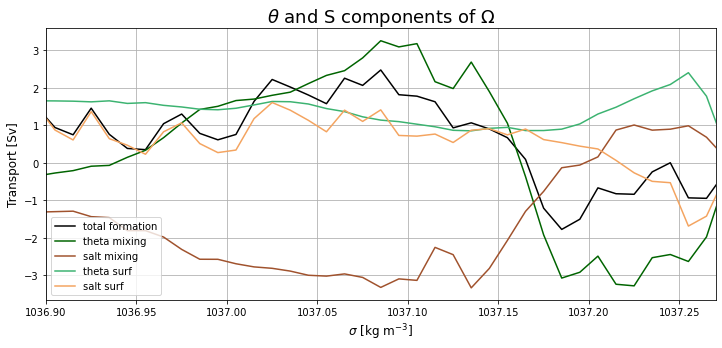

In [38]:
(wmt_budget_terms.omega_trans_rate/1e6).mean(dim='time').plot(figsize=(12,5), label='total formation', color='k')
(wmt_budget_terms.omega_mix_th/1e6).mean(dim='time').plot(label='theta mixing', color='darkgreen')
(wmt_budget_terms.omega_mix_slt/1e6).mean(dim='time').plot(label='salt mixing', color='sienna')
(wmt_budget_terms.omega_surf_th/1e6).mean(dim='time').plot(label='theta surf', color='mediumseagreen')
(wmt_budget_terms.omega_surf_slt/1e6).mean(dim='time').plot(label='salt surf', color='sandybrown')
plt.legend()
plt.grid()
plt.xlim(1036.90, 1037.27)
#plt.ylim(-10, 10)
plt.xlabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
plt.ylabel(r'Transport [Sv]', fontsize=12)
plt.title(r'$\theta$ and S components of $\Omega$', fontsize=18);

## Monthly Climatology

## BOTTOM Monthly Climatology

In [39]:
def anomaly(da):
    clim = da.groupby('time.month').mean(dim='time')
    anom = da.groupby('time.month') - clim
    #anom_chunk = anom.chunk({'time':12})
    anom_rolled = anom.rolling(time=73).mean(dim='time') #yearly rolling mean to remove seasonal cycle
    return anom_rolled

In [40]:
#1037.115 to include 1037.125 when slicing
anom_ds = (wmt_budget_terms.sel(sigma2_bin=slice(1037.115, 1037.5)))/1e6

In [41]:
def clim(da):
    clim = da.groupby('time.month').mean(dim='time')
    #anom_rolled = anom.rolling(time=12).mean(dim='time')
    return clim

In [42]:
clim_ds = anom_ds

In [43]:
clim_ds

<xarray.Dataset>
Dimensions:               (sigma2_bin: 37, time: 366)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 2006-01-01 ... 2010-12-31
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 1.543 5.113 ... 0.0 0.0
    R1_slt                (time, sigma2_bin) float64 -11.05 -11.21 ... 0.0 0.0
    R1_th                 (time, sigma2_bin) float64 -4.189 2.476 ... 0.0 0.0
    R2                    (time, sigma2_bin) float64 10.26 6.176 ... 0.0 0.0
    R2_slt                (time, sigma2_bin) float64 26.71 26.19 ... 0.0 0.0
    R2_th                 (time, sigma2_bin) float64 -1.039 -4.534 ... 0.0 0.0
    ...                    ...
    omega_trans_rate_th   (time, sigma2_bin) float64 3.866 3.695 ... 0.0 0.0
    psi_adv               (time, sigma2_bin) float64 -5.16 -9.305 ... 0.0 0.0
    psi_vel               (time, sigma2_bin) float64 -15.42 -15.48 ... -0.0 -0.0
    omega_surf            (time, sigma2_bin) float32 -15.26 -11.52 ... 0.0 0.0
    omega_surf_slt        (time, sigma2_bin) float32 -9.226 -5.709 ... 0.0 0.0
    omega_surf_th         (time, sigma2_bin) float32 -6.035 -5.815 ... 0.0 0.0

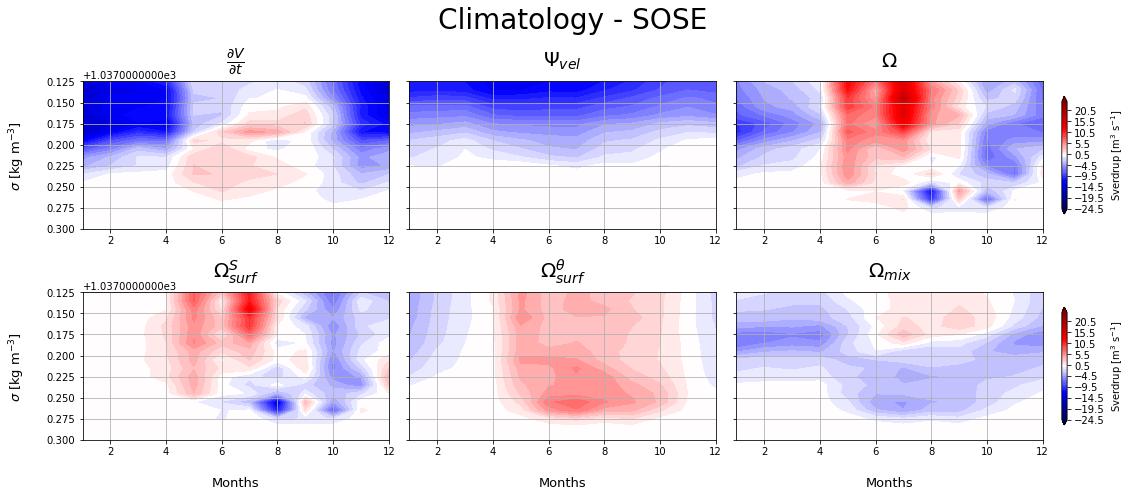

In [44]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

levels = np.arange(-25, 25) + 0.5

dVdt_clim = clim(clim_ds.dVdt)
c = ax[0,0].contourf(dVdt_clim.month, 
                   dVdt_clim.sigma2_bin,
                   dVdt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1037.125)

psi_vel_clim = clim(clim_ds.psi_vel)
c_psi = ax[0,1].contourf(psi_vel_clim.month, psi_vel_clim.sigma2_bin, psi_vel_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
ax[0,1].grid()

omega_clim = clim(clim_ds.omega_trans_rate)
c_omega = ax[0,2].contourf(omega_clim.month, omega_clim.sigma2_bin, omega_clim.T,
                           cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
#ax[0,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[0,1].set_xlabel('Time', fontsize=14)
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
ax[0,2].grid()

omega_surf_slt_clim = clim(clim_ds.omega_surf_slt)
c_surf_slt = ax[1,0].contourf(omega_surf_slt_clim.month, 
                                omega_surf_slt_clim.sigma2_bin, 
                                omega_surf_slt_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_slt, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[1,0])
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=13, labelpad=20)
ax[1,0].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax[1,0].grid()

omega_surf_th_clim = clim(clim_ds.omega_surf_th)
c_surf_th = ax[1,1].contourf(omega_surf_th_clim.month, omega_surf_th_clim.sigma2_bin, 
                        omega_surf_th_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_surf_th, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[1,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,1].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
ax[1,1].grid()

omega_mix__clim = clim(clim_ds.omega_mix)
c_mix = ax[1,2].contourf(omega_mix__clim.month, omega_mix__clim.sigma2_bin, omega_mix__clim.T, 
                        cmap='seismic', levels=levels, extend='both')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
#ax[1,2].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
ax[1,2].set_xlabel('Months', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
ax[1,2].grid()

plt.suptitle('Climatology - SOSE', fontsize=28)
plt.tight_layout();

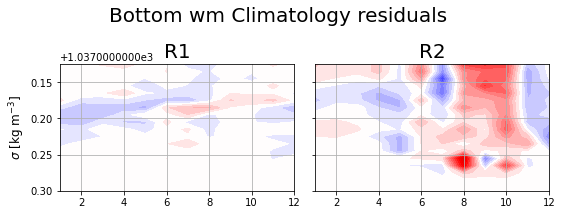

In [45]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

levels = np.arange(-20, 20) + 0.5

R1_clim = clim(clim_ds.R1)
c = ax0.contourf(R1_clim.month, 
                   R1_clim.sigma2_bin,
                   R1_clim.T, cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}]$', ax=ax[0,0])
ax0.set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=12)
#ax[0,0].set_xlabel('Time', fontsize=14)
ax0.set_title('R1', fontsize=20)
ax0.grid()
ax0.set_ylim(1037.3, 1037.125)

R2_clim = clim(clim_ds.R2)
c_psi = ax1.contourf(R2_clim.month, R2_clim.sigma2_bin, R2_clim.T,
                         cmap='seismic', levels=levels, extend='both')
#plt.colorbar(c_psi, shrink=0.8, label=r'Sverdrup [$\frac{m^3}{s}$]', ax=ax[0,1])
#ax[1,1].set_ylabel(r'$\sigma [\frac{kg}{m^3}]$', fontsize=14)
#ax[1,1].set_xlabel('Time', fontsize=14)
ax1.set_title('R2', fontsize=20)
ax1.grid()


plt.suptitle('Bottom wm Climatology residuals', fontsize=20)
plt.tight_layout();

In [46]:
clim_sose = xr.merge([dVdt_clim.rename('dVdt_clim'), psi_vel_clim.rename('psi_vel_clim'), 
                      omega_clim.rename('omega_clim'), omega_mix__clim.rename('omega_mix__clim'), 
                      omega_surf_slt_clim.rename('omega_surf_slt_clim'), omega_surf_th_clim.rename('omega_surf_th_clim'),
                      R1_clim.rename('R1_clim'), R2_clim.rename('R2_clim')])
clim_sose

<xarray.Dataset>
Dimensions:              (sigma2_bin: 37, month: 12)
Coordinates:
  * sigma2_bin           (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * month                (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    dVdt_clim            (month, sigma2_bin) float64 -15.1 -15.77 ... 0.0 0.0
    psi_vel_clim         (month, sigma2_bin) float64 -11.24 -10.92 ... 0.0 0.0
    omega_clim           (month, sigma2_bin) float64 -5.687 -5.945 ... 0.0 0.0
    omega_mix__clim      (month, sigma2_bin) float64 -1.142 -1.562 ... 0.0 0.0
    omega_surf_slt_clim  (month, sigma2_bin) float32 -0.1787 -0.1328 ... 0.0 0.0
    omega_surf_th_clim   (month, sigma2_bin) float32 -4.367 -4.25 ... 0.0 0.0
    R1_clim              (month, sigma2_bin) float64 0.264 -0.2598 ... 0.0 0.0
    R2_clim              (month, sigma2_bin) float64 1.566 1.361 ... 0.0 0.0

### $\frac{\partial V}{\partial t}$

In [47]:
#remember we are switching signs!
dVdt_clim_bot = - dVdt_clim.isel(sigma2_bin=-1) + dVdt_clim.sel(sigma2_bin=0, method='nearest')
dVdt_clim_bot.load()

<xarray.DataArray 'dVdt' (month: 12)>
array([-15.0980946 , -13.02046204, -12.62156575, -10.55059977,
        -1.47820325,  -1.83107446,  -1.72478996,  -0.96613704,
        -1.98515821,  -6.89967441, -12.36799975, -15.03599545])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

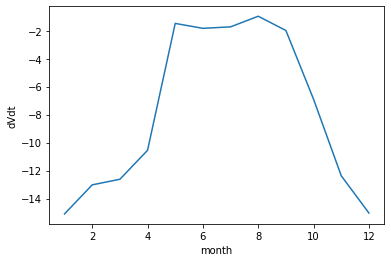

In [64]:
dVdt_clim_bot.plot();

### $\Psi$

In [48]:
#remember we are switching signs!
psi_clim_bot = - psi_vel_clim.isel(sigma2_bin=-1) + psi_vel_clim.isel(sigma2_bin=0)
psi_clim_bot.load()

<xarray.DataArray 'psi_vel' (month: 12)>
array([-11.24067461, -11.03335954, -11.55353865, -12.93178935,
       -12.91147344, -12.51689038, -12.59154919, -11.4564169 ,
       -10.34869157,  -8.83656217,  -7.71951361,  -7.90617391])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

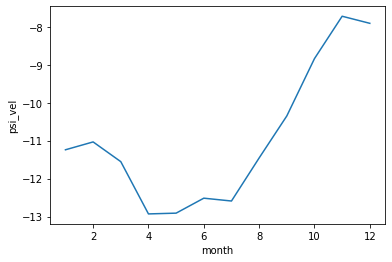

In [66]:
psi_clim_bot.plot();

### $\Omega$

In [67]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th']

In [49]:
omega_clim_bot = clim(bdy_omegas[3])
omega_clim_bot.load()

<xarray.DataArray 'omega_trans_rate' (month: 12)>
array([-5.68723178, -3.47583642, -2.52136703, -0.88037291, 12.30288996,
        6.13122271, 15.44591468,  4.67533315,  0.50352431, -4.7353096 ,
       -2.9873182 , -7.28182744])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [50]:
bdy_omegas[8].name

'omega_surf_th'

In [51]:
omega_surf_slt_clim_bot = clim(bdy_omegas[7]).load()
omega_surf_th_clim_bot = clim(bdy_omegas[8]).load()
omega_mix_clim_bot = clim(bdy_omegas[0]).load()

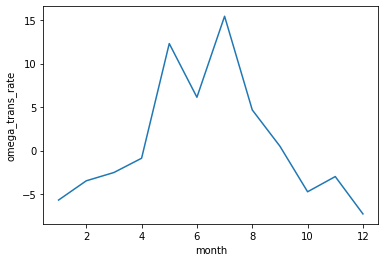

In [71]:
omega_clim_bot.plot();

### Residuals

In [52]:
#remember we are switching signs!
R1_clim_bot = - R1_clim.isel(sigma2_bin=-1) + R1_clim.isel(sigma2_bin=0)
R1_clim_bot.load()

<xarray.DataArray 'R1' (month: 12)>
array([ 0.26400385,  0.28971551,  0.65343718,  1.4264053 , -0.16367264,
        0.45742312, -0.79041925, -0.97120472,  0.07899653,  0.0796814 ,
        0.6022375 ,  0.26529539])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [53]:
#remember we are switching signs!
R2_clim_bot = - R2_clim.isel(sigma2_bin=-1) + R2_clim.isel(sigma2_bin=0)
R2_clim_bot.load()

<xarray.DataArray 'R2' (month: 12)>
array([ 1.56640642,  1.19963591,  0.80006948,  1.8351786 , -0.70593304,
        4.09725081, -3.78871844,  6.78624217,  7.78108505,  6.5925917 ,
       -2.26328423, -0.11306089])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

### __Bottom climatology budget__

In [54]:
bot_omega_clim  = clim(bdy_omegas[3])

In [55]:
clim_budget = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot + R1_clim_bot + R2_clim_bot
clim_budget

<xarray.DataArray (month: 12)>
array([5.98480333e-04, 6.17495939e-04, 1.66723193e-04, 2.14043145e-05,
       1.40971927e-05, 8.07308736e-05, 1.77695450e-05, 9.07435286e-05,
       7.25246191e-05, 7.57392408e-05, 1.21214292e-04, 2.28592696e-04])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [56]:
clim_budget1 = - dVdt_clim_bot + psi_clim_bot + bot_omega_clim + R1_clim_bot + R2_clim_bot
clim_budget1

<xarray.DataArray (month: 12)>
array([5.98480333e-04, 6.17495939e-04, 1.66723193e-04, 2.14043145e-05,
       1.40971927e-05, 8.07308736e-05, 1.77695450e-05, 9.07435286e-05,
       7.25246191e-05, 7.57392408e-05, 1.21214292e-04, 2.28592696e-04])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [57]:
#makes no diff doing `clim()` on clim_ds.omega terms or bdy_omegas omega terms
clim_budget - clim_budget1

<xarray.DataArray (month: 12)>
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [58]:
clim_bdgt_nores = - dVdt_clim_bot + psi_clim_bot + omega_clim_bot 
clim_bdgt_nores

<xarray.DataArray (month: 12)>
array([-1.82981179, -1.48873392, -1.45333993, -3.2615625 ,  0.86961977,
       -4.55459321,  4.57915545, -5.81494671, -7.86000905, -6.67219736,
        1.66116794, -0.1520059 ])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

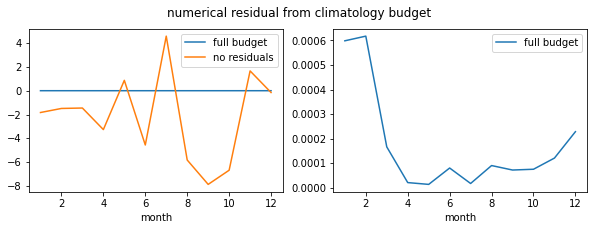

In [59]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
clim_budget.plot(ax=ax0, label='full budget')
clim_bdgt_nores.plot(ax=ax0, label='no residuals')

clim_budget.plot(ax=ax1, label='full budget')

ax0.legend()
ax1.legend()
plt.suptitle('numerical residual from climatology budget');

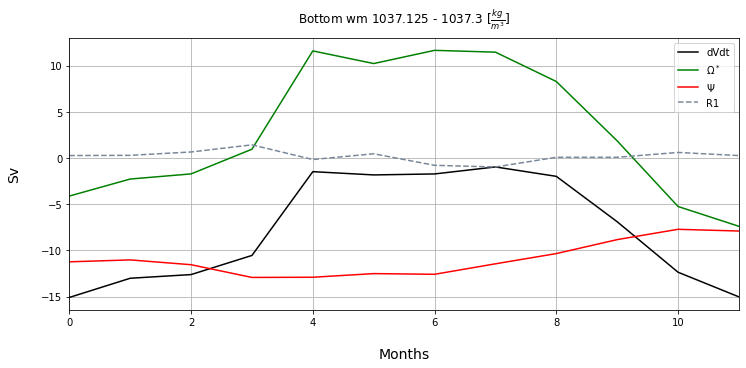

In [60]:
plt.figure(figsize=(12,5))
plt.plot(dVdt_clim_bot, label='dVdt', color='k')
plt.plot((omega_clim_bot+R2_clim_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_clim_bot, label=r'$\Psi$', color='red')
plt.plot(R1_clim_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_clim_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Months', fontsize=14, labelpad=20)
plt.xlim(0, 11)

plt.legend()
plt.grid();

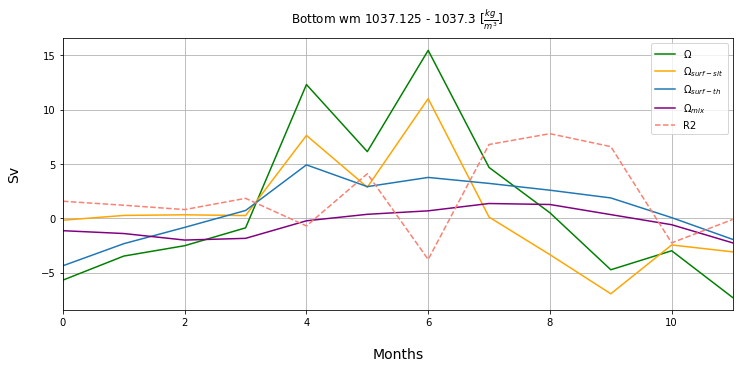

In [61]:
plt.figure(figsize=(12,5))
plt.plot(omega_clim_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_clim_bot, label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_clim_bot, label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_clim_bot, label=r'$\Omega_{mix}$', color='purple')
plt.plot(R2_clim_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Months', fontsize=14, labelpad=20)
plt.xlim(0, 11)

plt.legend()
plt.grid();

In [62]:
omega_clim_bot.mean('month')

<xarray.DataArray 'omega_trans_rate' ()>
array(0.95746845)

In [63]:
(omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot).mean('month')

<xarray.DataArray ()>
array(0.95746865)

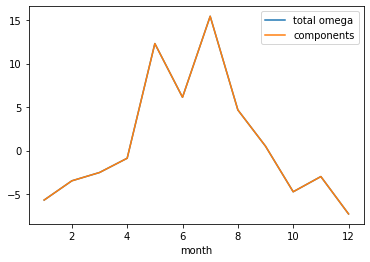

In [64]:
omega_clim_bot.plot(label='total omega')
(omega_surf_slt_clim_bot + omega_surf_th_clim_bot + omega_mix_clim_bot).plot(label='components')

plt.legend();

## Anomaly

In [82]:
import warnings
warnings.filterwarnings("ignore")

## BOTTOM Anomaly

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
year_start_index =[0,73, 146, 220, 293]

In [67]:
wmt

<xarray.Dataset>
Dimensions:               (time: 438, sigma2_bin: 999)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.028e+03 1.028e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_slt                (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R1_th                 (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    R2                    (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_slt                (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    R2_th                 (time, sigma2_bin) float64 1.318e+07 1.318e+07 ... 0.0
    ...                    ...
    omega_trans_rate_th   (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_adv               (time, sigma2_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    psi_vel               (time, sigma2_bin) float64 -1.318e+07 ... -0.0
    omega_surf            (time, sigma2_bin) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_slt        (time, sigma2_bin) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    omega_surf_th         (time, sigma2_bin) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [68]:
anom_ds

<xarray.Dataset>
Dimensions:               (sigma2_bin: 37, time: 366)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 2006-01-01 ... 2010-12-31
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 1.543 5.113 ... 0.0 0.0
    R1_slt                (time, sigma2_bin) float64 -11.05 -11.21 ... 0.0 0.0
    R1_th                 (time, sigma2_bin) float64 -4.189 2.476 ... 0.0 0.0
    R2                    (time, sigma2_bin) float64 10.26 6.176 ... 0.0 0.0
    R2_slt                (time, sigma2_bin) float64 26.71 26.19 ... 0.0 0.0
    R2_th                 (time, sigma2_bin) float64 -1.039 -4.534 ... 0.0 0.0
    ...                    ...
    omega_trans_rate_th   (time, sigma2_bin) float64 3.866 3.695 ... 0.0 0.0
    psi_adv               (time, sigma2_bin) float64 -5.16 -9.305 ... 0.0 0.0
    psi_vel               (time, sigma2_bin) float64 -15.42 -15.48 ... -0.0 -0.0
    omega_surf            (time, sigma2_bin) float32 -15.26 -11.52 ... 0.0 0.0
    omega_surf_slt        (time, sigma2_bin) float32 -9.226 -5.709 ... 0.0 0.0
    omega_surf_th         (time, sigma2_bin) float32 -6.035 -5.815 ... 0.0 0.0

In [108]:
#1037.115 to include 1037.125 when slicing
anom_whole_timeseries_unrolled = (wmt.sel(sigma2_bin=slice(1037.115, 1037.5))/1e6).groupby('time.month') - clim(clim_ds)
anom_whole_timeseries = anom_whole_timeseries_unrolled.rolling(time=73).mean(dim='time')

In [109]:
anom_whole_timeseries

<xarray.Dataset>
Dimensions:               (sigma2_bin: 37, time: 438)
Coordinates:
  * sigma2_bin            (sigma2_bin) float64 1.037e+03 1.037e+03 ... 1.037e+03
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
    month                 (time) int64 1 1 1 1 1 1 2 2 ... 12 12 12 12 12 12 12
Data variables: (12/24)
    R1                    (time, sigma2_bin) float64 nan nan ... -1.046e-18
    R1_slt                (time, sigma2_bin) float64 nan nan ... -2.852e-19
    R1_th                 (time, sigma2_bin) float64 nan nan ... -9.505e-20
    R2                    (time, sigma2_bin) float64 nan nan ... 2.471e-18
    R2_slt                (time, sigma2_bin) float64 nan nan ... 1.901e-19
    R2_th                 (time, sigma2_bin) float64 nan nan ... -1.04e-20
    ...                    ...
    omega_trans_rate_th   (time, sigma2_bin) float64 nan nan ... 1.485e-21
    psi_adv               (time, sigma2_bin) float64 nan nan ... 2.471e-18
    psi_vel               (time, sigma2_bin) float64 nan nan nan ... 0.0 0.0 0.0
    omega_surf            (time, sigma2_bin) float32 nan nan ... -1.123e-09
    omega_surf_slt        (time, sigma2_bin) float32 nan nan ... -1.735e-09
    omega_surf_th         (time, sigma2_bin) float32 nan nan ... 1.435e-11

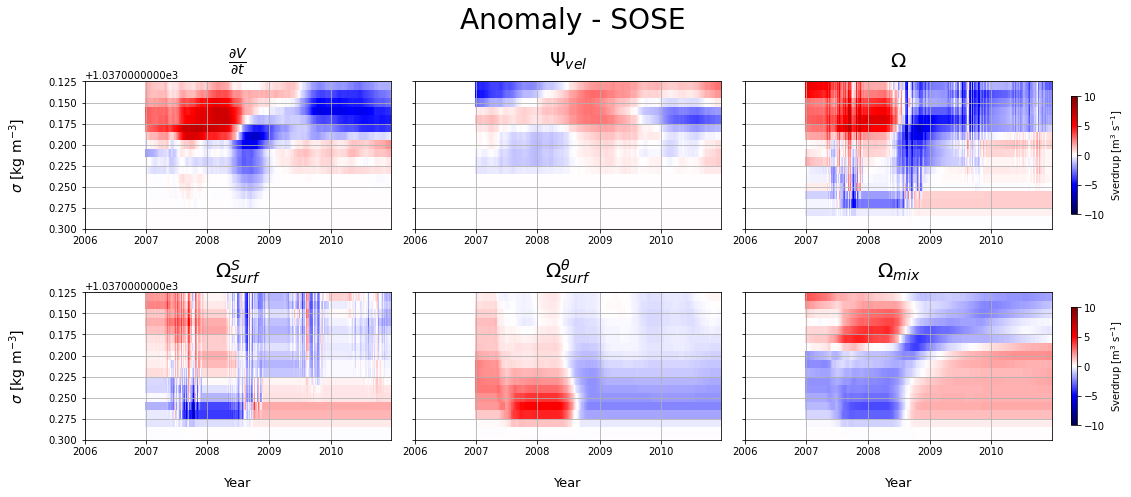

In [90]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom.dVdt.drop('month').time.values, 
                   anom.dVdt.sigma2_bin, 
                   anom.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=14, labelpad=20)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax[0,0].set_xticks(anom.dVdt.time[year_start_index])
#ax[0,0].set_xticks(np.arange(anom.dVdt.time[year_start_index].dt.year[0], anom.dVdt.time[year_start_index].dt.year[-1], 1))
ax[0,0].set_xticklabels(np.arange(2006, 2011))
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1037.125)


c_psi = ax[0,1].pcolormesh(anom.psi_vel.time.values, anom.psi_vel.sigma2_bin, anom.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
#ax[0,1].set_ylim(1037.3, 1036.5)
ax[0,1].set_xticks(anom.dVdt.time[year_start_index])
ax[0,1].set_xticklabels(np.arange(2006, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom.omega_trans_rate.time.values, anom.omega_trans_rate.sigma2_bin, anom.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
ax[0,2].set_xticks(anom.dVdt.time[year_start_index])
ax[0,2].set_xticklabels(np.arange(2006, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom.omega_surf_slt.time.values, 
                                anom.omega_surf_slt.sigma2_bin, 
                                anom.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=14, labelpad=20)
ax[1,0].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax[1,0].set_xticks(anom.dVdt.time[year_start_index])
ax[1,0].set_xticklabels(np.arange(2006, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom.omega_surf_th.time.values, anom.omega_surf_th.sigma2_bin, 
                        anom.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
#ax[1,1].set_ylim(1037.3, 1036.5)
ax[1,1].set_xticks(anom.dVdt.time[year_start_index])
ax[1,1].set_xticklabels(np.arange(2006, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom.omega_mix.time.values, anom.omega_mix.sigma2_bin, anom.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
ax[1,2].set_xticks(anom.dVdt.time[year_start_index])
ax[1,2].set_xticklabels(np.arange(2006, 2011))
ax[1,2].grid()

plt.suptitle('Anomaly - SOSE', fontsize=28)
plt.tight_layout();

In [71]:
year_start_index_whole_series = [0,73, 146, 219, 292, 365]

In [110]:
anom_whole_timeseries.time[year_start_index_whole_series]

<xarray.DataArray 'time' (time: 6)>
array(['2005-01-06T00:00:00.000000000', '2006-01-06T00:00:00.000000000',
       '2007-01-06T00:00:00.000000000', '2008-01-06T00:00:00.000000000',
       '2009-01-05T00:00:00.000000000', '2010-01-05T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2006-01-06 ... 2010-01-05
    month    (time) int64 1 1 1 1 1 1
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

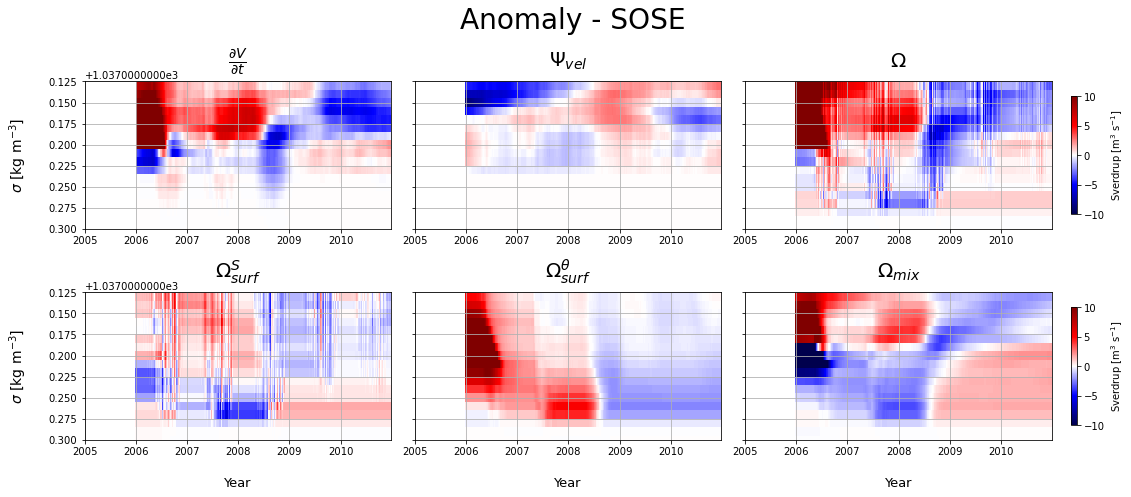

In [111]:
fig, ax = plt.subplots(2, 3, figsize=(16, 7), sharey=True, gridspec_kw={'width_ratios': [2.4,2.4,3]})

c = ax[0,0].pcolormesh(anom_whole_timeseries.dVdt.drop('month').time.values, 
                   anom_whole_timeseries.dVdt.sigma2_bin, 
                   anom_whole_timeseries.dVdt.T, vmin=-10, vmax=10, cmap='seismic')
ax[0,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=14, labelpad=20)
ax[0,0].set_title(r'$\frac{\partial V}{\partial t}$', fontsize=20, pad=15)
ax[0,0].set_xticks(anom_whole_timeseries.time[year_start_index_whole_series])
#ax[0,0].set_xticks(np.arange(anom.dVdt.time[year_start_index].dt.year[0], anom.dVdt.time[year_start_index].dt.year[-1], 1))
ax[0,0].set_xticklabels(np.arange(2005, 2011))
ax[0,0].grid()
ax[0,0].set_ylim(1037.3, 1037.125)


c_psi = ax[0,1].pcolormesh(anom_whole_timeseries.psi_vel.time.values, 
                           anom_whole_timeseries.psi_vel.sigma2_bin, 
                           anom_whole_timeseries.psi_vel.T,
                        vmin=-10, vmax=10, cmap='seismic')
ax[0,1].set_title(r'$\Psi_{vel}$', fontsize=20, pad=15)
#ax[0,1].set_ylim(1037.3, 1036.5)
ax[0,1].set_xticks(anom_whole_timeseries.dVdt.time[year_start_index_whole_series])
ax[0,1].set_xticklabels(np.arange(2005, 2011))
ax[0,1].grid()

c_omega = ax[0,2].pcolormesh(anom_whole_timeseries.omega_trans_rate.time.values, 
                             anom_whole_timeseries.omega_trans_rate.sigma2_bin, 
                             anom_whole_timeseries.omega_trans_rate.T,
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_omega, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[0,2])
ax[0,2].set_title(r'$\Omega$', fontsize=20, pad=15)
ax[0,2].set_xticks(anom_whole_timeseries.dVdt.time[year_start_index_whole_series])
ax[0,2].set_xticklabels(np.arange(2005, 2011))
ax[0,2].grid()

c_surf_slt = ax[1,0].pcolormesh(anom_whole_timeseries.omega_surf_slt.time.values, 
                                anom_whole_timeseries.omega_surf_slt.sigma2_bin, 
                                anom_whole_timeseries.omega_surf_slt.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,0].set_ylabel(r'$\sigma$ [kg m$^{-3}$]', fontsize=14, labelpad=20)
ax[1,0].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,0].set_title('$\Omega^{S}_{surf}$', fontsize=20, pad=15)
ax[1,0].set_xticks(anom_whole_timeseries.dVdt.time[year_start_index_whole_series])
ax[1,0].set_xticklabels(np.arange(2005, 2011))
ax[1,0].grid()

c_surf_th = ax[1,1].pcolormesh(anom_whole_timeseries.omega_surf_th.time.values, 
                               anom_whole_timeseries.omega_surf_th.sigma2_bin, 
                        anom_whole_timeseries.omega_surf_th.T, vmin=-10, vmax=10, cmap='seismic')
ax[1,1].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,1].set_title(r'$\Omega^{\theta}_{surf}$', fontsize=20, pad=15)
#ax[1,1].set_ylim(1037.3, 1036.5)
ax[1,1].set_xticks(anom_whole_timeseries.dVdt.time[year_start_index_whole_series])
ax[1,1].set_xticklabels(np.arange(2005, 2011))
ax[1,1].grid()

c_mix = ax[1,2].pcolormesh(anom_whole_timeseries.omega_mix.time.values, 
                           anom_whole_timeseries.omega_mix.sigma2_bin, 
                           anom_whole_timeseries.omega_mix.T, 
                        vmin=-10, vmax=10, cmap='seismic')
plt.colorbar(c_mix, shrink=0.8, label=r'Sverdrup [m$^3$ s$^{-1}$]', ax=ax[1,2])
ax[1,2].set_xlabel('Year', fontsize=13, labelpad=20)
ax[1,2].set_title(r'$\Omega_{mix}$', fontsize=20, pad=15)
ax[1,2].set_xticks(anom_whole_timeseries.dVdt.time[year_start_index_whole_series])
ax[1,2].set_xticklabels(np.arange(2005, 2011))
ax[1,2].grid()

plt.suptitle('Anomaly - SOSE', fontsize=28)
plt.tight_layout();

In [112]:
anom_bot = - anom_whole_timeseries.isel(sigma2_bin=-1) + anom_whole_timeseries.isel(sigma2_bin=0)
anom_bot

<xarray.Dataset>
Dimensions:               (time: 438)
Coordinates:
  * time                  (time) datetime64[ns] 2005-01-06 ... 2010-12-31
    month                 (time) int64 1 1 1 1 1 1 2 2 ... 12 12 12 12 12 12 12
Data variables: (12/24)
    R1                    (time) float64 nan nan nan ... 0.2088 0.2509 0.2496
    R1_slt                (time) float64 nan nan nan ... -3.313 -3.282 -3.163
    R1_th                 (time) float64 nan nan nan nan ... 2.01 2.107 2.025
    R2                    (time) float64 nan nan nan nan ... -1.334 -1.32 -1.321
    R2_slt                (time) float64 nan nan nan nan ... -1.129 -1.064 -1.13
    R2_th                 (time) float64 nan nan nan nan ... -3.03 -3.092 -3.04
    ...                    ...
    omega_trans_rate_th   (time) float64 nan nan nan ... -3.317 -3.277 -3.223
    psi_adv               (time) float64 nan nan nan nan ... 1.491 1.516 1.53
    psi_vel               (time) float64 nan nan nan nan ... 2.825 2.836 2.85
    omega_surf            (time) float32 nan nan nan ... -1.405 -1.405 -1.406
    omega_surf_slt        (time) float32 nan nan nan ... -1.566 -1.571 -1.571
    omega_surf_th         (time) float32 nan nan nan nan ... 0.161 0.1656 0.1647

### $\frac{\partial V}{\partial t}$

In [113]:
#remember we're switching signs!
dVdt_anom_bot = - anom_whole_timeseries.dVdt.isel(sigma2_bin=-1) + anom_whole_timeseries.dVdt.isel(sigma2_bin=0)
dVdt_anom_bot.load()

<xarray.DataArray 'dVdt' (time: 438)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  7.53221771e+00,  7.57099718e+00,  7.66337752e+00,
        7.74770161e+00,  7.80758888e+00,  7.84365406e+00,  7.92767253e+00,
...
       -1.86805163e+00, -1.91379427e+00, -1.95049348e+00, -1.85246796e+00,
       -1.74405400e+00, -1.75685374e+00, -1.85109956e+00, -1.86628338e+00,
       -1.90954352e+00, -1.91850879e+00, -1.91381240e+00, -1.98836961e+00,
       -2.06479085e+00, -2.05642687e+00, -2.05771440e+00, -2.04190568e+00,
       -2.07856619e+00, -2.05006828e+00, -1.97790065e+00, -1.95540484e+00,
       -2.01956276e+00, -2.03406449e+00, -2.07433893e+00, -2.10213275e+00,
       -2.13071290e+00, -2.25741452e+00, -2.30471057e+00, -2.34395965e+00,
       -2.32544993e+00, -2.39181302e+00, -2.41172203e+00, -2.37767176e+00,
       -2.46881753e+00, -2.61556350e+00, -2.67166742e+00, -2.64195118e+00,
       -2.64923972e+00, -2.69840993e+00, -2.74393667e+00, -2.78295164e+00,
       -2.71177355e+00, -2.63240995e+00, -2.50602716e+00, -2.42550626e+00,
       -2.36120038e+00, -2.34414318e+00, -2.34154527e+00, -2.30982457e+00,
       -2.26497237e+00, -2.25549291e+00, -2.21487566e+00, -2.21051311e+00,
       -2.15506100e+00, -2.09160682e+00, -2.03876088e+00, -2.03523432e+00,
       -1.83818858e+00, -1.81547344e+00, -1.73487701e+00, -1.78262276e+00,
       -1.71925594e+00, -1.64335079e+00, -1.53145826e+00, -1.53533774e+00,
       -1.62470457e+00, -1.57729954e+00, -1.56944986e+00, -1.57095736e+00,
       -1.60880837e+00, -1.63258639e+00, -1.61056601e+00, -1.57878040e+00,
       -1.58785241e+00, -1.60155326e+00, -1.59103682e+00, -1.51192446e+00,
       -1.42532652e+00, -1.38745230e+00])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

In [114]:
dVdt_anom_bot - anom_bot.dVdt

<xarray.DataArray 'dVdt' (time: 438)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

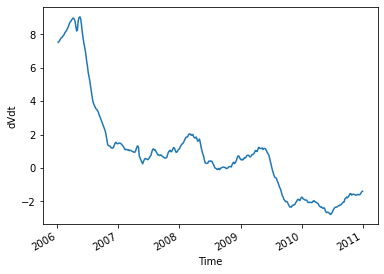

In [115]:
dVdt_anom_bot.plot();

### $\Psi$

In [116]:
#remember we're switching signs!
psi_anom_bot = anom_bot.psi_vel

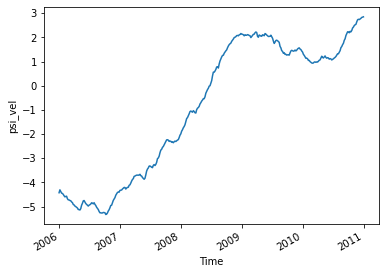

In [117]:
psi_anom_bot.plot();

### $\Omega$

In [118]:
omega_anom_bot = (- anom_whole_timeseries.omega_trans_rate.isel(sigma2_bin=-1) 
                  + anom_whole_timeseries.omega_trans_rate.sel(sigma2_bin=1037.125, method='nearest'))
omega_anom_bot.load()

<xarray.DataArray 'omega_trans_rate' (time: 438)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan, 13.73283707, 13.71291947, 13.78811739,
       13.86508099, 13.94903905, 13.94216664, 13.9971806 , 14.04031318,
       14.09064052, 14.11833366, 14.22128655, 14.29650982, 14.24324356,
       14.35766124, 14.34907826, 14.50416444, 14.49527658, 14.49705993,
       14.45811113, 14.38318126, 14.63853308, 14.2122848 , 14.38911507,
       14.50710265, 13.82971106, 13.79634806, 13.06210492, 12.01919804,
...
       -4.63721065, -1.50053184, -4.96121099, -4.38892496, -1.63390943,
       -3.80969526, -3.39270853, -2.65311967, -2.37189453, -4.39121981,
       -4.91465683, -4.16561083, -2.00050948, -1.93067582, -2.36038583,
       -3.19885473, -1.53336084, -2.37216379, -2.42206374, -1.03354222,
       -1.92696525, -1.99524797, -1.97940635, -1.12961019, -1.48820768,
       -1.50958524, -1.5032873 , -1.50866034, -1.51246717, -1.48939101,
       -1.4830152 , -1.49097937, -1.49963813, -1.50869527, -1.50494779,
       -1.50451074, -1.50387868, -1.49382891, -1.48991726, -1.49340886,
       -1.5553259 , -1.57183799, -1.60951973, -1.70646467, -1.61408298,
       -1.42984756, -1.46437025, -0.95764706, -1.26729716, -1.54475721,
       -2.26548226, -2.54950383, -1.73945081, -2.24105269, -2.88053554,
       -1.90598827, -2.01972556, -2.39115766, -1.70353494, -1.8663339 ,
       -2.71116897, -2.75892386, -2.36325324, -1.64564813, -1.72380921,
       -2.11323892, -2.31381464, -2.34790165, -2.43936673, -3.03813909,
       -3.82997587, -2.30587241, -2.12373866, -2.29113844, -2.07494389,
       -1.6197813 , -1.62399333, -1.77478793, -1.38714318, -1.06569599,
       -0.2978609 , -3.02007656, -1.76658126, -1.72437904, -1.61346097,
       -2.15851697, -3.2050619 , -2.07430594, -2.03768423, -3.08228036,
       -3.15867153, -3.40892053, -3.1143027 , -2.98574347, -3.3912124 ,
       -3.21167809, -3.19181654, -3.16674795])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

In [119]:
omega_anom_bot - anom_bot.omega_trans_rate

<xarray.DataArray 'omega_trans_rate' (time: 438)>
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

In [120]:
omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th']

In [121]:
omega_surf_slt_anom_bot = anom_bot.omega_surf_slt
omega_surf_th_anom_bot = anom_bot.omega_surf_th
omega_mix_anom_bot = anom_bot.omega_mix

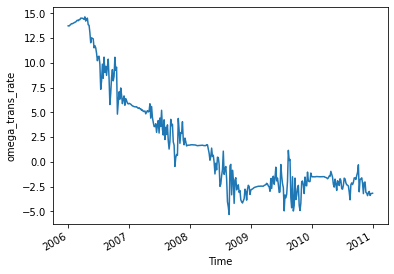

In [122]:
omega_anom_bot.plot();

### Residuals

In [123]:
R1_anom_bot = anom_bot.R1
R2_anom_bot = anom_bot.R2

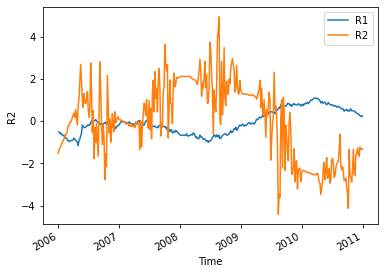

In [124]:
R1_anom_bot.plot(label='R1')
R2_anom_bot.plot(label='R2')
plt.legend();

In [102]:
dVdt_anom_bot.time[73]

<xarray.DataArray 'time' ()>
array('2007-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2007-01-01
    month    int64 1
Attributes:
    axis:           T
    long_name:      Time
    standard_name:  time

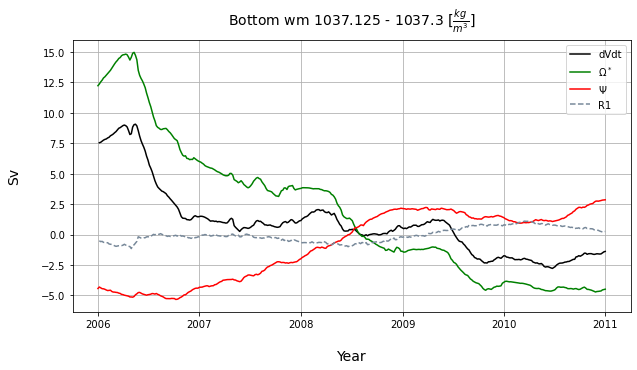

In [125]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, (omega_anom_bot+R2_anom_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.plot(R1_anom_bot.time, R1_anom_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
#plt.xlim(dVdt_anom_bot.time[73], dVdt_anom_bot.time[-1]) #2007-2010

plt.legend()
plt.grid();

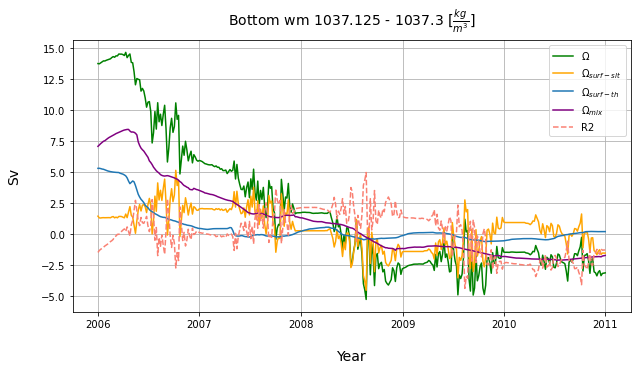

In [127]:
fig = plt.subplots(figsize=(10,5))
plt.plot(omega_anom_bot.time, omega_anom_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_anom_bot.time, omega_surf_slt_anom_bot, 
         label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_anom_bot.time, omega_surf_th_anom_bot, 
         label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_anom_bot.time, omega_mix_anom_bot, label=r'$\Omega_{mix}$', color='purple')
plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
#plt.xlim(omega_anom_bot.time[73], dVdt_anom_bot.time[-1]) #2007-2010

plt.legend()
plt.grid();

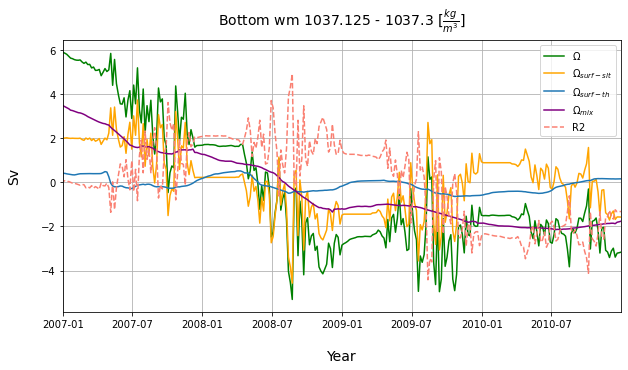

In [104]:
fig = plt.subplots(figsize=(10,5))
plt.plot(omega_anom_bot.time, omega_anom_bot, label=r'$\Omega$', color='green')
plt.plot(omega_surf_slt_anom_bot.time, omega_surf_slt_anom_bot, 
         label=r'$\Omega_{surf-slt}$', color='orange')
plt.plot(omega_surf_th_anom_bot.time, omega_surf_th_anom_bot, 
         label=r'$\Omega_{surf-th}$', color='C0')
plt.plot(omega_mix_anom_bot.time, omega_mix_anom_bot, label=r'$\Omega_{mix}$', color='purple')
plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(omega_anom_bot.time[73], dVdt_anom_bot.time[-1]) #2007-2010

plt.legend()
plt.grid();

### __Bottom anomaly budget__

In [128]:
(- dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot).mean('time')

<xarray.DataArray ()>
array(2.94113747e-05)

In [129]:
(- dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot).isel(time=260)

<xarray.DataArray ()>
array(-7.12015184e-05)
Coordinates:
    time     datetime64[ns] 2008-07-29
    month    int64 7

In [130]:
anom_budget = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot + R1_anom_bot + R2_anom_bot
anom_budget

<xarray.DataArray (time: 438)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  7.48851978e-05,  1.04305710e-04,  1.08144468e-04,
        1.19075768e-04,  1.38126907e-04,  1.53300972e-04,  1.86122401e-04,
...
       -5.53874765e-05, -4.08918294e-05, -3.21159351e-05, -3.57757391e-05,
       -3.56457972e-05, -2.58086358e-05, -1.90365882e-05, -2.44279205e-05,
       -1.63897518e-05, -1.13191515e-05, -1.36137426e-05, -1.25981289e-05,
       -1.32705177e-05, -2.89257428e-05, -3.58601398e-05, -2.89041995e-05,
       -3.90130710e-05, -4.39209402e-05, -4.55732979e-05, -6.29262167e-05,
       -6.01844487e-05, -5.79067673e-05, -5.68933377e-05, -5.21662579e-05,
       -5.66596584e-05, -5.79118470e-05, -4.34921864e-05, -4.64673941e-05,
       -4.51399211e-05, -4.34180079e-05, -4.49107274e-05, -5.53223818e-05,
       -4.78924439e-05, -5.78675886e-05, -5.94152967e-05, -6.16426909e-05,
       -6.91505479e-05, -4.85507092e-05, -4.51888627e-05, -5.21895037e-05,
       -4.55712510e-05, -4.79214507e-05, -6.80524332e-05, -6.36468879e-05,
       -5.21853370e-05, -5.64384509e-05, -5.32517010e-05, -5.92483662e-05,
       -5.29897852e-05, -5.71824410e-05, -5.00095242e-05, -6.11451902e-05,
       -5.62107141e-05, -6.07898856e-05, -5.75470887e-05, -5.24112381e-05,
       -5.22417014e-05, -5.43898965e-05, -7.04388307e-05, -7.14395446e-05,
       -6.91072586e-05, -7.44059599e-05, -6.77947641e-05, -7.23057237e-05,
       -6.99900872e-05, -8.83471101e-05, -9.31433358e-05, -8.74122744e-05,
       -8.20168252e-05, -8.90615194e-05, -8.79974647e-05, -8.22700989e-05,
       -9.11759041e-05, -9.35105575e-05, -1.05731203e-04, -1.07994770e-04,
       -9.76538582e-05, -9.35814371e-05])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

In [131]:
anom_bdgt_nores = - dVdt_anom_bot + psi_anom_bot + omega_anom_bot
anom_bdgt_nores

<xarray.DataArray (time: 438)>
array([            nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,             nan,             nan,             nan,
                   nan,  1.87242053e+00,  1.84464023e+00,  1.75731347e+00,
        1.74483920e+00,  1.63902256e+00,  1.59957643e+00,  1.51339181e+00,
...
        1.50665319e+00,  1.43529859e+00,  1.46598226e+00,  2.15930220e+00,
        1.64762550e+00,  1.54586401e+00,  1.60170017e+00,  1.55122688e+00,
        1.53208986e+00,  1.56855805e+00,  1.54389542e+00,  1.54507164e+00,
        1.61305293e+00,  1.54474318e+00,  1.52374889e+00,  1.47828766e+00,
        1.50610078e+00,  1.49849037e+00,  1.46620012e+00,  1.44683773e+00,
        1.43048811e+00,  1.44723515e+00,  1.44311130e+00,  1.40745181e+00,
        1.56817961e+00,  1.89740618e+00,  1.98366340e+00,  2.60706152e+00,
        2.23033475e+00,  1.99392542e+00,  1.33740594e+00,  1.06095921e+00,
        1.89794576e+00,  1.51323173e+00,  9.52408492e-01,  1.88308190e+00,
        1.72872927e+00,  1.42889956e+00,  2.14876025e+00,  1.98273299e+00,
        1.09125260e+00,  9.87068269e-01,  1.28948157e+00,  1.95235049e+00,
        1.84767795e+00,  1.50173503e+00,  1.35010496e+00,  1.28343321e+00,
        1.20922059e+00,  6.67827482e-01, -4.09277642e-02,  1.52543832e+00,
        1.73102986e+00,  1.55599539e+00,  1.84162268e+00,  2.35722357e+00,
        2.29067123e+00,  2.19160734e+00,  2.57829968e+00,  2.94593250e+00,
        3.61223314e+00,  8.71866536e-01,  1.99528459e+00,  2.09769709e+00,
        2.39919373e+00,  1.84529356e+00,  8.53920362e-01,  2.01720069e+00,
        2.11159176e+00,  1.19360623e+00,  1.17888322e+00,  9.19477655e-01,
        1.20837440e+00,  1.37694439e+00,  9.89496927e-01,  1.12540479e+00,
        1.06915197e+00,  1.07080743e+00])
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

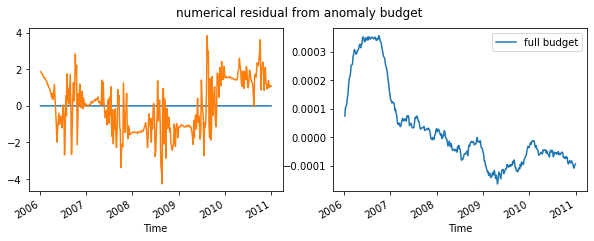

In [132]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,3))
anom_budget.plot(ax=ax0, label='full budget')
anom_bdgt_nores.plot(ax=ax0, label='no residuals')

anom_budget.plot(ax=ax1, label='full budget')

plt.legend()
plt.suptitle('numerical residual from anomaly budget');

## Trying to quiet noise in Omega curve

In [110]:
terms_in_boundary = wmt_budget_terms.sel(sigma2_bin=slice(1037.0, 1037.2)).mean('sigma2_bin')/1e6
terms_in_boundary

<xarray.Dataset>
Dimensions:               (time: 366)
Coordinates:
  * time                  (time) datetime64[ns] 2006-01-01 ... 2010-12-31
Data variables: (12/24)
    R1                    (time) float64 1.301 -1.382 -1.374 ... -1.437 1.54
    R1_slt                (time) float64 -13.06 -17.1 -16.37 ... -11.64 -7.882
    R1_th                 (time) float64 -2.718 -1.764 -1.148 ... -0.2955 0.7569
    R2                    (time) float64 6.166 0.7736 4.727 ... -0.1902 0.2675
    R2_slt                (time) float64 15.12 10.52 14.0 ... 8.567 7.994
    R2_th                 (time) float64 -1.039 -3.868 -2.952 ... -3.299 -3.197
    ...                    ...
    omega_trans_rate_th   (time) float64 -5.399 -5.97 -5.723 ... -1.444 -1.695
    psi_adv               (time) float64 -1.751 -5.101 -1.596 ... -5.648 -4.262
    psi_vel               (time) float64 -7.918 -5.875 -6.324 ... -5.457 -4.53
    omega_surf            (time) float32 -13.07 -8.044 -11.01 ... -1.306 -1.921
    omega_surf_slt        (time) float32 -7.483 -1.8 -5.084 ... 0.2707 0.03767
    omega_surf_th         (time) float32 -5.586 -6.243 -5.922 ... -1.577 -1.958

In [111]:
broad_omegas = list()
broad_bdy_omegas = list()

for var in terms_in_boundary.data_vars:
    if var == 'omega_total':
        continue 
    elif var == 'omega_total_slt':
        continue
    elif var == 'omega_total_th':
        continue
    elif var.startswith('omega'):
        broad_omegas.append(var)
        broad_bdy_omegas.append(terms_in_boundary.data_vars[var])

In [112]:
broad_omegas

['omega_mix',
 'omega_mix_slt',
 'omega_mix_th',
 'omega_trans_rate',
 'omega_trans_rate_slt',
 'omega_trans_rate_th',
 'omega_surf',
 'omega_surf_slt',
 'omega_surf_th']

In [113]:
len(broad_omegas)

9

In [114]:
len(broad_bdy_omegas)

9

In [115]:
broad_omega_anom_bot = anomaly(broad_bdy_omegas[3])
broad_omega_anom_bot.load()

<xarray.DataArray 'omega_trans_rate' (time: 366)>
array([        nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,  2.28802162,  2.37334253,  2.37178738,
        2.39473064,  2.35045384,  2.31953673,  2.37481251,  2.31027653,
        2.31255708,  2.29854275,  2.35258752,  2.285164  ,  2.23370807,
        2.36891866,  2.29717303,  2.3549875 ,  2.21830231,  2.32859724,
        2.19558544,  2.34364276,  2.59459156,  2.14228886,  2.50828659,
        2.55631555,  1.8983147 ,  2.07603309,  3.00482741,  1.86092179,
...
       -3.93948141, -2.48493235, -0.32528586, -2.73891047, -2.07451915,
       -1.02373892, -0.18788055, -4.11093509, -3.53869738, -3.44761281,
       -1.7044323 , -0.55432738, -0.66022912, -2.19437494,  0.07866036,
       -1.21972742, -1.20784376, -0.07939495, -0.92969406, -0.96185218,
       -1.14626279, -0.34915588, -0.81842402, -0.80044049, -0.75206627,
       -0.72907006, -0.71366168, -0.69415863, -0.67469103, -0.66977064,
       -0.65620361, -0.64853061, -0.62370669, -0.61156405, -0.61603056,
       -0.61586938, -0.53539615, -0.40333063, -0.81680594, -0.73460758,
       -0.81972714, -0.98124123, -0.84859325, -0.65375579, -0.77926271,
       -0.21364684, -0.82661388, -0.68678402, -1.28344638, -1.59336914,
       -0.7525246 , -1.27071559, -2.24000329, -0.51024545, -0.50234077,
       -1.3519589 , -0.14331374, -0.59476873, -1.71152338, -1.35694799,
       -0.86596898,  0.01835758,  0.01810692, -0.94765502, -1.46455431,
       -1.06575601, -1.41208297, -1.87059709, -2.95653865, -1.62009474,
       -1.32503914, -1.00925838, -1.03387004,  0.15228136, -0.89469478,
       -0.97745319,  0.15623109,  0.09099414,  0.90051169, -2.9371817 ,
        0.74497133, -0.29241103,  0.28727701, -0.64007391, -2.30476633,
       -1.35094105, -0.27156653, -2.40112667, -1.82203857, -2.02548851,
       -1.27957148, -1.46430577, -1.98153775, -1.61024309, -1.68495865,
       -1.66957528])
Coordinates:
  * time     (time) datetime64[ns] 2006-01-01 2006-01-06 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 1 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

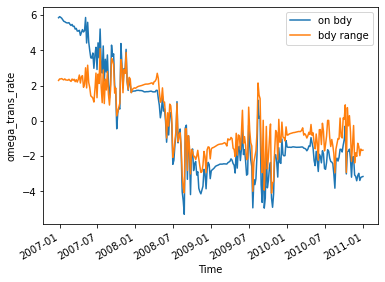

In [116]:
omega_anom_bot.plot(label='on bdy')
broad_omega_anom_bot.plot(label='bdy range')
plt.legend();

## Defining Omega as an averaged boundary range doesn't quiet the noise that much but resampling monthly does

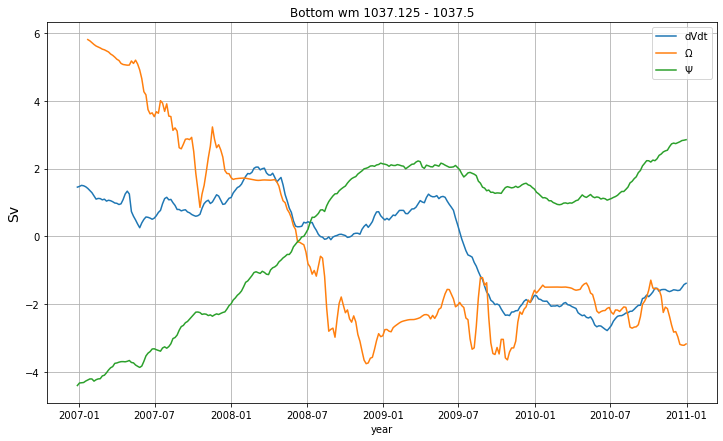

In [117]:
fig = plt.subplots(figsize=(12,7))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt')
plt.plot(omega_anom_bot.time, omega_anom_bot.rolling(time=6).mean(dim='time'), label=r'$\Omega$')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$')
plt.title('Bottom wm 1037.125 - 1037.5')
plt.ylabel('Sv', fontsize=14)
plt.xlabel('year')

plt.legend()
plt.grid();

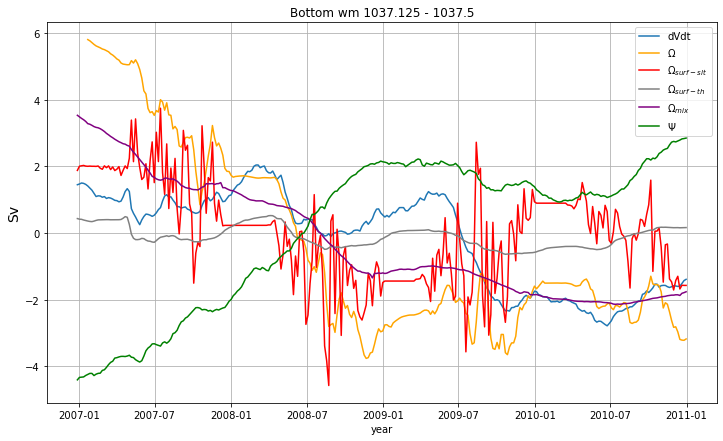

In [118]:
fig = plt.subplots(figsize=(12,7))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='C0')
plt.plot(omega_anom_bot.time, omega_anom_bot.rolling(time=6).mean(dim='time'), label=r'$\Omega$', color='orange')
plt.plot(omega_surf_slt_anom_bot.time, omega_surf_slt_anom_bot, label=r'$\Omega_{surf-slt}$', color='red')
plt.plot(omega_surf_th_anom_bot.time, omega_surf_th_anom_bot, label=r'$\Omega_{surf-th}$', color='grey')
plt.plot(omega_mix_anom_bot.time, omega_mix_anom_bot, label=r'$\Omega_{mix}$', color='purple')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='green')
plt.title('Bottom wm 1037.125 - 1037.5')
plt.ylabel('Sv', fontsize=14)
plt.xlabel('year')

plt.legend()
plt.grid();

## Indices

In [133]:
indices

<xarray.Dataset>
Dimensions:          (time: 60)
Coordinates:
  * time             (time) datetime64[ns] 2006-01-01 2006-02-01 ... 2010-12-01
Data variables:
    enso             (time) float32 -0.7034 -0.6278 -0.392 ... -1.47 -1.44
    fw_flx           (time) float32 0.06174 0.3266 -0.6006 ... -0.1008 0.9542
    heat_flx         (time) float32 0.9099 0.5741 0.6695 ... 0.2288 -0.04812
    sam              (time) float64 0.09698 -0.8633 0.9374 ... 2.196 0.05417
    sose             (time) float32 -0.1024 -0.3163 -0.7164 ... -0.4328 -0.4636
    windstress_curl  (time) float32 0.1545 0.4456 0.4518 ... -2.025 -0.3768

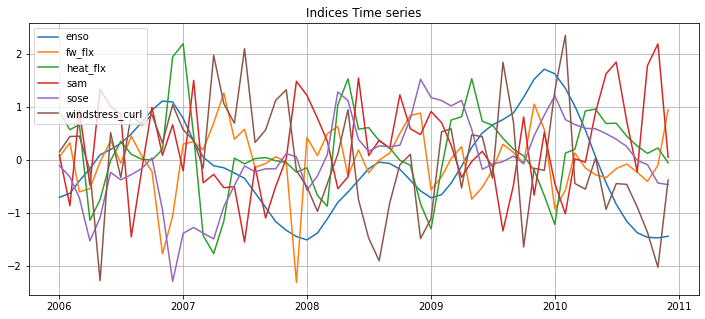

In [134]:
fig, ax = plt.subplots(figsize=(12,5))
for i in indices.variables:
    if i =='time':
        continue
    ax.plot(indices.time, indices[i], label=f'{indices[i].name}')
    
plt.legend()
plt.grid()
plt.title('Indices Time series');

## Heat map of Corralation matrices

In [135]:
import seaborn as sn

In [136]:
indices_df = indices.to_dataframe()
indices_df.head()

,enso,fw_flx,heat_flx,sam,sose,windstress_curl
time,,,,,,
2006-01-01,-0.703412,0.061736,0.909883,0.096981,-0.102403,0.154478
2006-02-01,-0.627783,0.326616,0.574079,-0.863304,-0.316302,0.445615
2006-03-01,-0.392023,-0.600639,0.669474,0.937425,-0.716384,0.451785
2006-04-01,-0.160018,-0.538129,-1.137979,-0.472696,-1.526455,-0.196582
2006-05-01,0.099242,-0.036327,-0.748289,1.336000,-1.089656,-2.279050


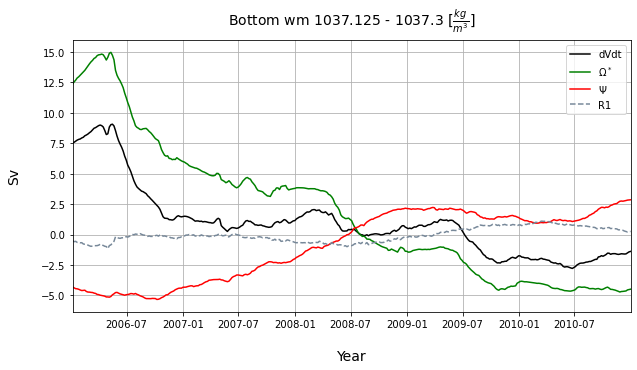

In [137]:
fig = plt.subplots(figsize=(10,5))
plt.plot(dVdt_anom_bot.time, dVdt_anom_bot, label='dVdt', color='k')
plt.plot(omega_anom_bot.time, (omega_anom_bot+R2_anom_bot), label=r'$\Omega^*$', color='green')
plt.plot(psi_anom_bot.time, psi_anom_bot, label=r'$\Psi$', color='red')
plt.plot(R1_anom_bot.time, R1_anom_bot, label='R1', color='lightslategray', linestyle='--')
#plt.plot(R2_anom_bot.time, R2_anom_bot, label='R2', color='salmon', linestyle='--')
plt.title(r'Bottom wm 1037.125 - 1037.3 [$\frac{kg}{m^3}$]', fontsize=14, pad=15)
plt.ylabel('Sv', fontsize=14, labelpad=20)
plt.xlabel('Year', fontsize=14, labelpad=20)
plt.xlim(dVdt_anom_bot.time[73], dVdt_anom_bot.time[-1]) #2007-2010

plt.legend()
plt.grid();

In [138]:
omega_star = omega_anom_bot + R2_anom_bot

In [139]:
ds = xr.merge([dVdt_anom_bot.rename('dvdt'), psi_anom_bot.rename('psi'), omega_star.rename('omega*')])
ds.drop('month')

<xarray.Dataset>
Dimensions:  (time: 438)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    dvdt     (time) float64 nan nan nan nan nan ... -1.591 -1.512 -1.425 -1.387
    psi      (time) float64 nan nan nan nan nan ... 2.761 2.79 2.825 2.836 2.85
    omega*   (time) float64 nan nan nan nan nan ... -4.632 -4.546 -4.512 -4.487

In [140]:
budget_df = ds.drop('month').resample(time='MS').mean().to_dataframe()

In [146]:
budget_df.head(13)

,dvdt,psi,omega*
time,,,
2005-01-01,NaN,NaN,NaN
2005-02-01,NaN,NaN,NaN
2005-03-01,NaN,NaN,NaN
2005-04-01,NaN,NaN,NaN
2005-05-01,NaN,NaN,NaN
2005-06-01,NaN,NaN,NaN
2005-07-01,NaN,NaN,NaN
2005-08-01,NaN,NaN,NaN
2005-09-01,NaN,NaN,NaN


### Deep Water Corr Matrix

### Bottom Waterr Corr Matrix

### Correlation matrix of all terms (deep, bottom, indices)

### Correlation matrix of all terms (budget & indices)

In [150]:
indices_df.head()

,enso,fw_flx,heat_flx,sam,sose,windstress_curl
time,,,,,,
2006-01-01,-0.703412,0.061736,0.909883,0.096981,-0.102403,0.154478
2006-02-01,-0.627783,0.326616,0.574079,-0.863304,-0.316302,0.445615
2006-03-01,-0.392023,-0.600639,0.669474,0.937425,-0.716384,0.451785
2006-04-01,-0.160018,-0.538129,-1.137979,-0.472696,-1.526455,-0.196582
2006-05-01,0.099242,-0.036327,-0.748289,1.336000,-1.089656,-2.279050


In [147]:
budget_ind = pd.concat([budget_df, indices_df], axis=1)
budget_ind.head(13)

,dvdt,psi,omega*,enso,fw_flx,heat_flx,sam,sose,windstress_curl
time,,,,,,,,,
2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


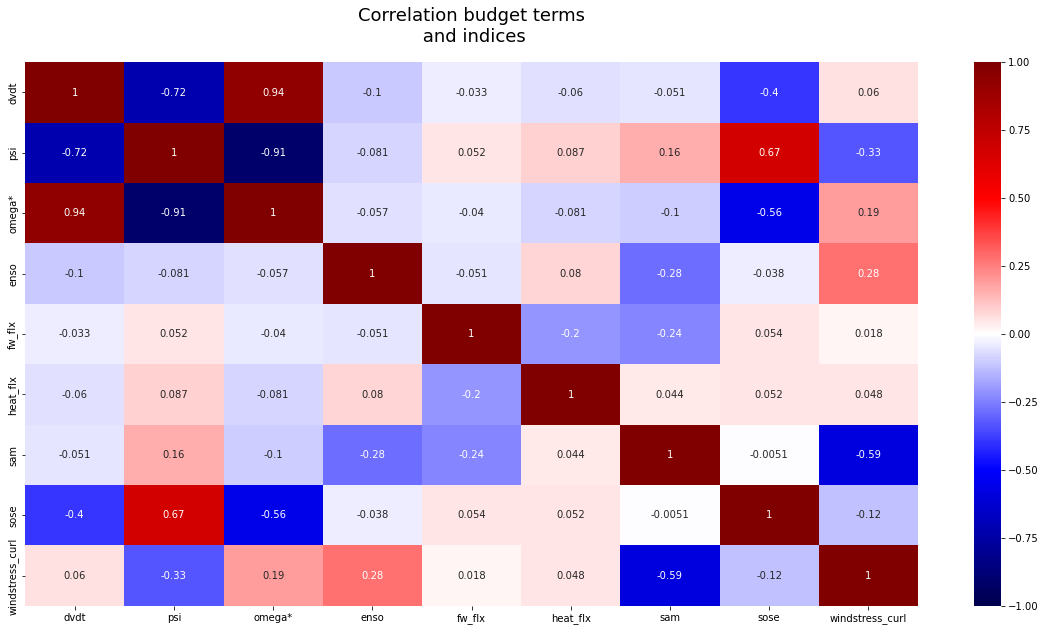

In [151]:
plt.figure(figsize=(20,10))
sn.heatmap(budget_ind.corr(), annot=True, cmap='seismic', vmin=-1, vmax=1)
plt.title('Correlation budget terms\n and indices', fontsize=18, pad=20.5);

In [152]:
corr = budget_ind.corr()
corr

,dvdt,psi,omega*,enso,fw_flx,heat_flx,sam,sose,windstress_curl
dvdt,1.000000,-0.721784,0.936791,-0.104923,-0.032755,-0.059553,-0.051311,-0.397497,0.059854
psi,-0.721784,1.000000,-0.912713,-0.080665,0.051883,0.087316,0.161069,0.669263,-0.333050
omega*,0.936791,-0.912713,1.000000,-0.056596,-0.039667,-0.080526,-0.101374,-0.557542,0.189614
enso,-0.104923,-0.080665,-0.056596,1.000000,-0.050652,0.080254,-0.283055,-0.037990,0.276552
fw_flx,-0.032755,0.051883,-0.039667,-0.050652,1.000000,-0.203783,-0.238027,0.053914,0.017578
heat_flx,-0.059553,0.087316,-0.080526,0.080254,-0.203783,1.000000,0.044157,0.052403,0.047809
sam,-0.051311,0.161069,-0.101374,-0.283055,-0.238027,0.044157,1.000000,-0.005067,-0.589282
sose,-0.397497,0.669263,-0.557542,-0.037990,0.053914,0.052403,-0.005067,1.000000,-0.117696
windstress_curl,0.059854,-0.333050,0.189614,0.276552,0.017578,0.047809,-0.589282,-0.117696,1.000000


In [153]:
corr.iloc[:, :3]

,dvdt,psi,omega*
dvdt,1.000000,-0.721784,0.936791
psi,-0.721784,1.000000,-0.912713
omega*,0.936791,-0.912713,1.000000
enso,-0.104923,-0.080665,-0.056596
fw_flx,-0.032755,0.051883,-0.039667
heat_flx,-0.059553,0.087316,-0.080526
sam,-0.051311,0.161069,-0.101374
sose,-0.397497,0.669263,-0.557542
windstress_curl,0.059854,-0.333050,0.189614


In [154]:
corr.iloc[0, 1]

-0.7217840566017895

In [155]:
dvdt_psi = corr.iloc[0, 1]
dvdt_omega = corr.iloc[0, 2]
psi_omega = corr.iloc[2, 1]

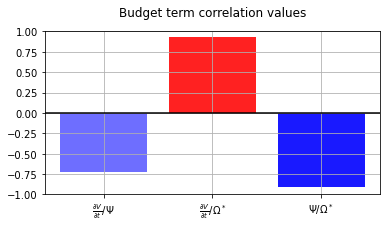

In [156]:
fig, ax0 = plt.subplots(1,1, figsize=(6,3))

ax0.bar(x=r'$\frac{\partial V}{\partial t}/\Psi$', height = dvdt_psi, color='Blue', alpha=0.57)
ax0.bar(x=r'$\frac{\partial V}{\partial t}/\Omega^*$', height = dvdt_omega, color='red', alpha=0.87)
ax0.bar(x=r'$\Psi/\Omega^*$', height= psi_omega, color='Blue', alpha=0.9)
ax0.axhline(y=0, color='k')
ax0.set_title(r'Budget term correlation values', fontsize=12, pad=15)
ax0.set_ylabel('')
ax0.grid()
ax0.set_ylim(-1,1);

In [157]:
# save df for corr-bars fig in stacked-figs dir
budget_ind.to_csv('sose_budgt_ind')